In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [4]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 33.9 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for peewee: filename=peewee-3.17.1-cp310-cp310-linux_x86_64.whl size=291649 sha256=aba39c3b67a05bd7f991f76a51ac43253d9953bbc550920c888cec33a747cbbf
  Stored in directory: /root/.cache/pip/wheels/d7/35/5c/1374782be033462df5f40174d8d879519d64ed8c25a1977554
Successfully built peewee


In [5]:
import yfinance as yf

In [6]:
apple_data = yf.download('AAPL', start=datetime.datetime(2015, 1, 1), end=date.today()).reset_index()
google_data = yf.download('GOOG', start=datetime.datetime(2015, 1, 1), end=date.today()).reset_index()
microsoft_data = yf.download('MSFT', start=datetime.datetime(2015, 1, 1), end=date.today()).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Apple Stock Analysis

In [7]:
apple_data.head()

Date       Open       High        Low      Close  Adj Close     Volume
0 2015-01-02  27.847500  27.860001  26.837500  27.332500  24.435270  212818400
1 2015-01-05  27.072500  27.162500  26.352501  26.562500  23.746895  257142000
2 2015-01-06  26.635000  26.857500  26.157499  26.565001  23.749125  263188400
3 2015-01-07  26.799999  27.049999  26.674999  26.937500  24.082140  160423600
4 2015-01-08  27.307501  28.037500  27.174999  27.972500  25.007433  237458000

In [8]:
apple_data.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [9]:
apple_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
apple_data['stock_type'] = 'AAPL'

In [11]:
# verifying the data if the stock splits have been adjusted
# Apple stock split happend to 1:4 ration on Aug 31 2020
apple_data[(apple_data['Date'] < '2020-09-05') & (apple_data['Date'] > '2020-08-26')]

Date        Open        High         Low       Close   Adj Close  \
1423 2020-08-27  127.142502  127.485001  123.832497  125.010002  122.472679   
1424 2020-08-28  126.012497  126.442497  124.577499  124.807503  122.274315   
1425 2020-08-31  127.580002  131.000000  126.000000  129.039993  126.420868   
1426 2020-09-01  132.759995  134.800003  130.529999  134.179993  131.456573   
1427 2020-09-02  137.589996  137.979996  127.000000  131.399994  128.732986   
1428 2020-09-03  126.910004  128.839996  120.500000  120.879997  118.426498   
1429 2020-09-04  120.070000  123.699997  110.889999  120.959999  118.504860   

         Volume stock_type  
1423  155552400       AAPL  
1424  187630000       AAPL  
1425  225702700       AAPL  
1426  151948100       AAPL  
1427  200119000       AAPL  
1428  257599600       AAPL  
1429  332607200       AAPL

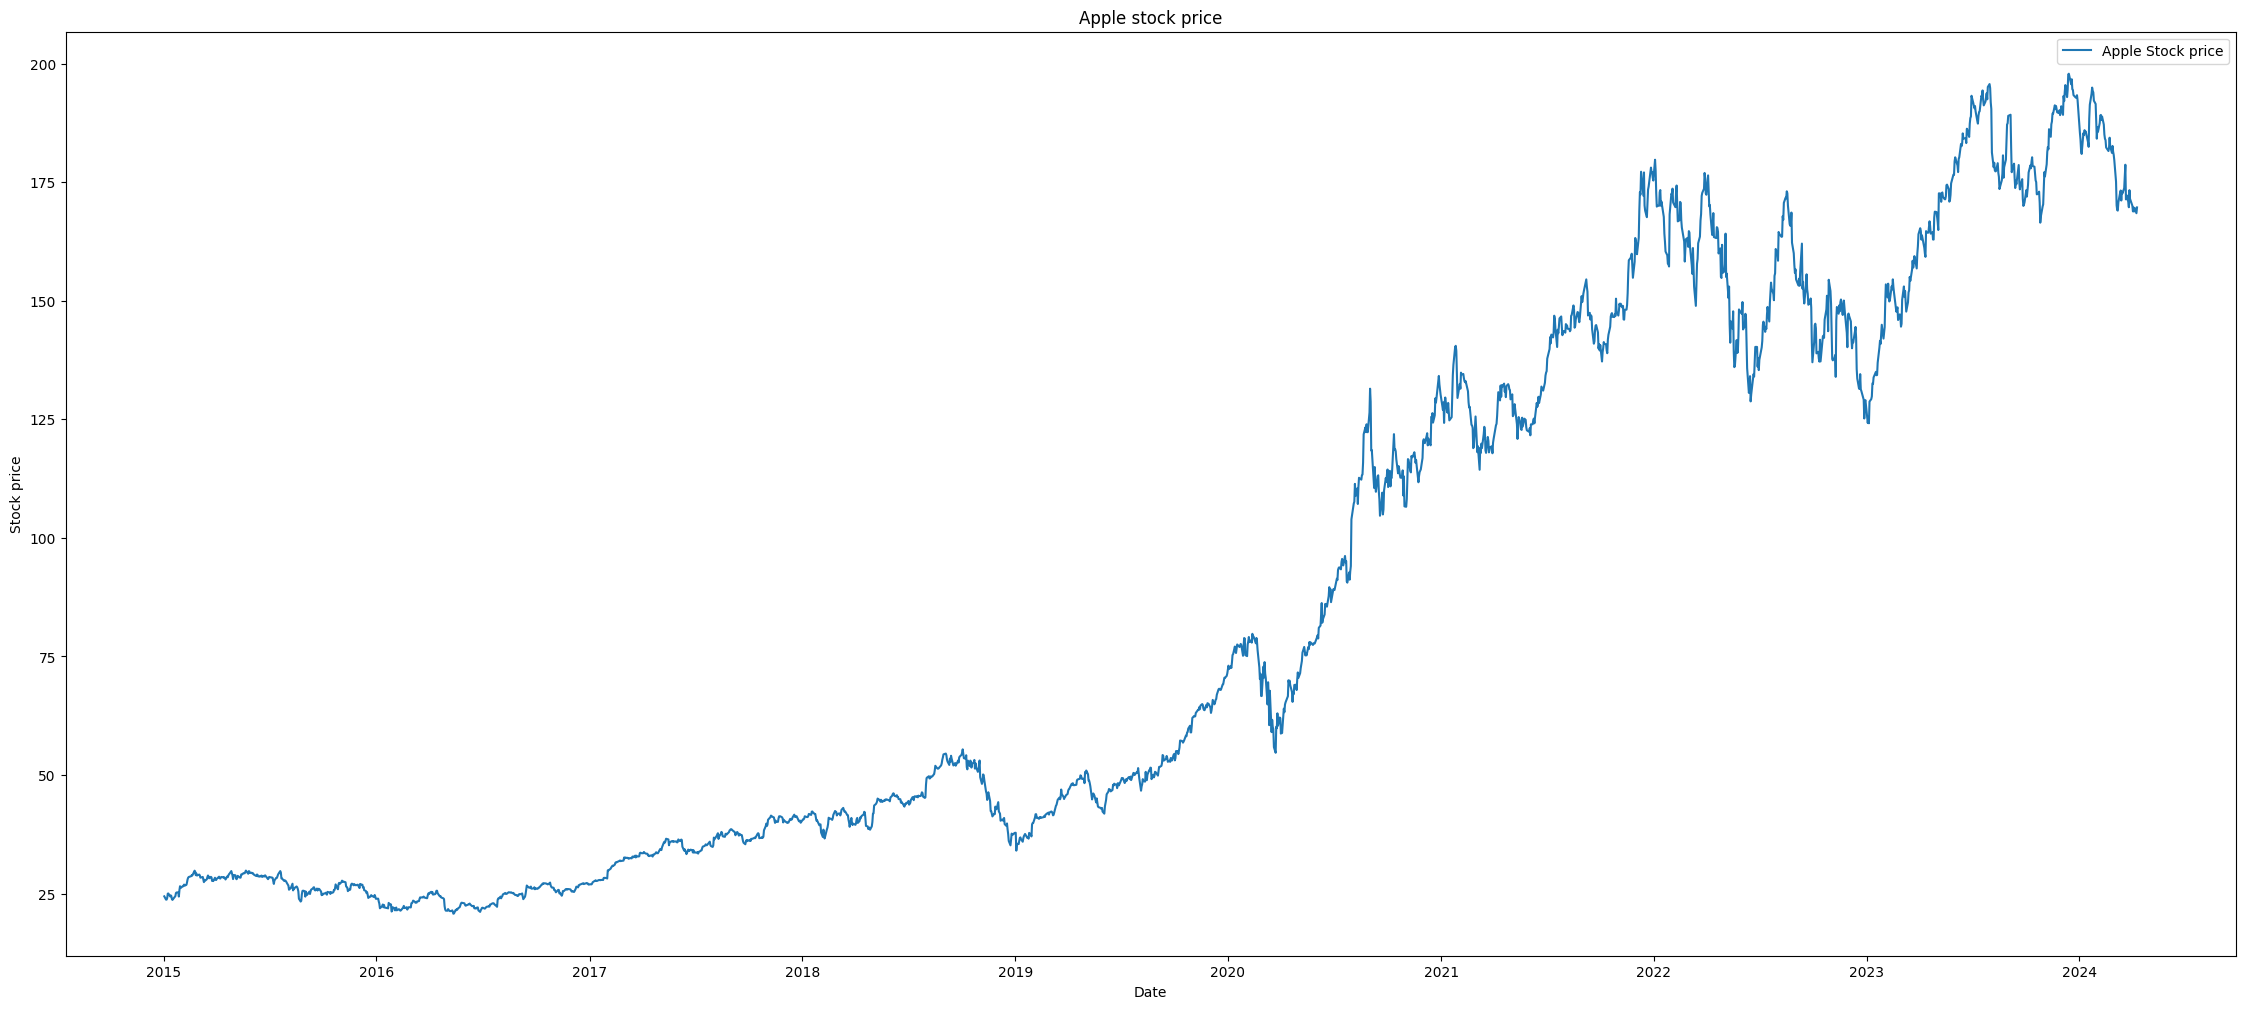

In [12]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(apple_data['Date'],apple_data['Adj Close'], label='Apple Stock price')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.title('Apple stock price')
plt.legend()
plt.show()

In [13]:
def get_technical_indicators(dataset, col_name):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset[col_name].rolling(window=7).mean()
    dataset['ma21'] = dataset[col_name].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = dataset[col_name].ewm(span=26).mean()
    dataset['12ema'] = dataset[col_name].ewm(span=12).mean()
    dataset['MACD'] = dataset['12ema']-dataset['26ema']

    # Create Bollinger Bands
    dataset['20sd'] = dataset[col_name].rolling(window = 21).std()
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset[col_name].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset[col_name]-1
    dataset['log_momentum'] = np.log(dataset['momentum'])
    return dataset

In [14]:
apple_df = get_technical_indicators(apple_data, 'Adj Close')

In [15]:
def plot_technical_indicators(dataset, col_name, last_days, stock_name):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    plt.figure(figsize=(30,20))
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset[col_name],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for {} - last {} days.'.format(stock_name, last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot

    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
#     plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
#     plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

<Figure size 1600x1000 with 0 Axes>

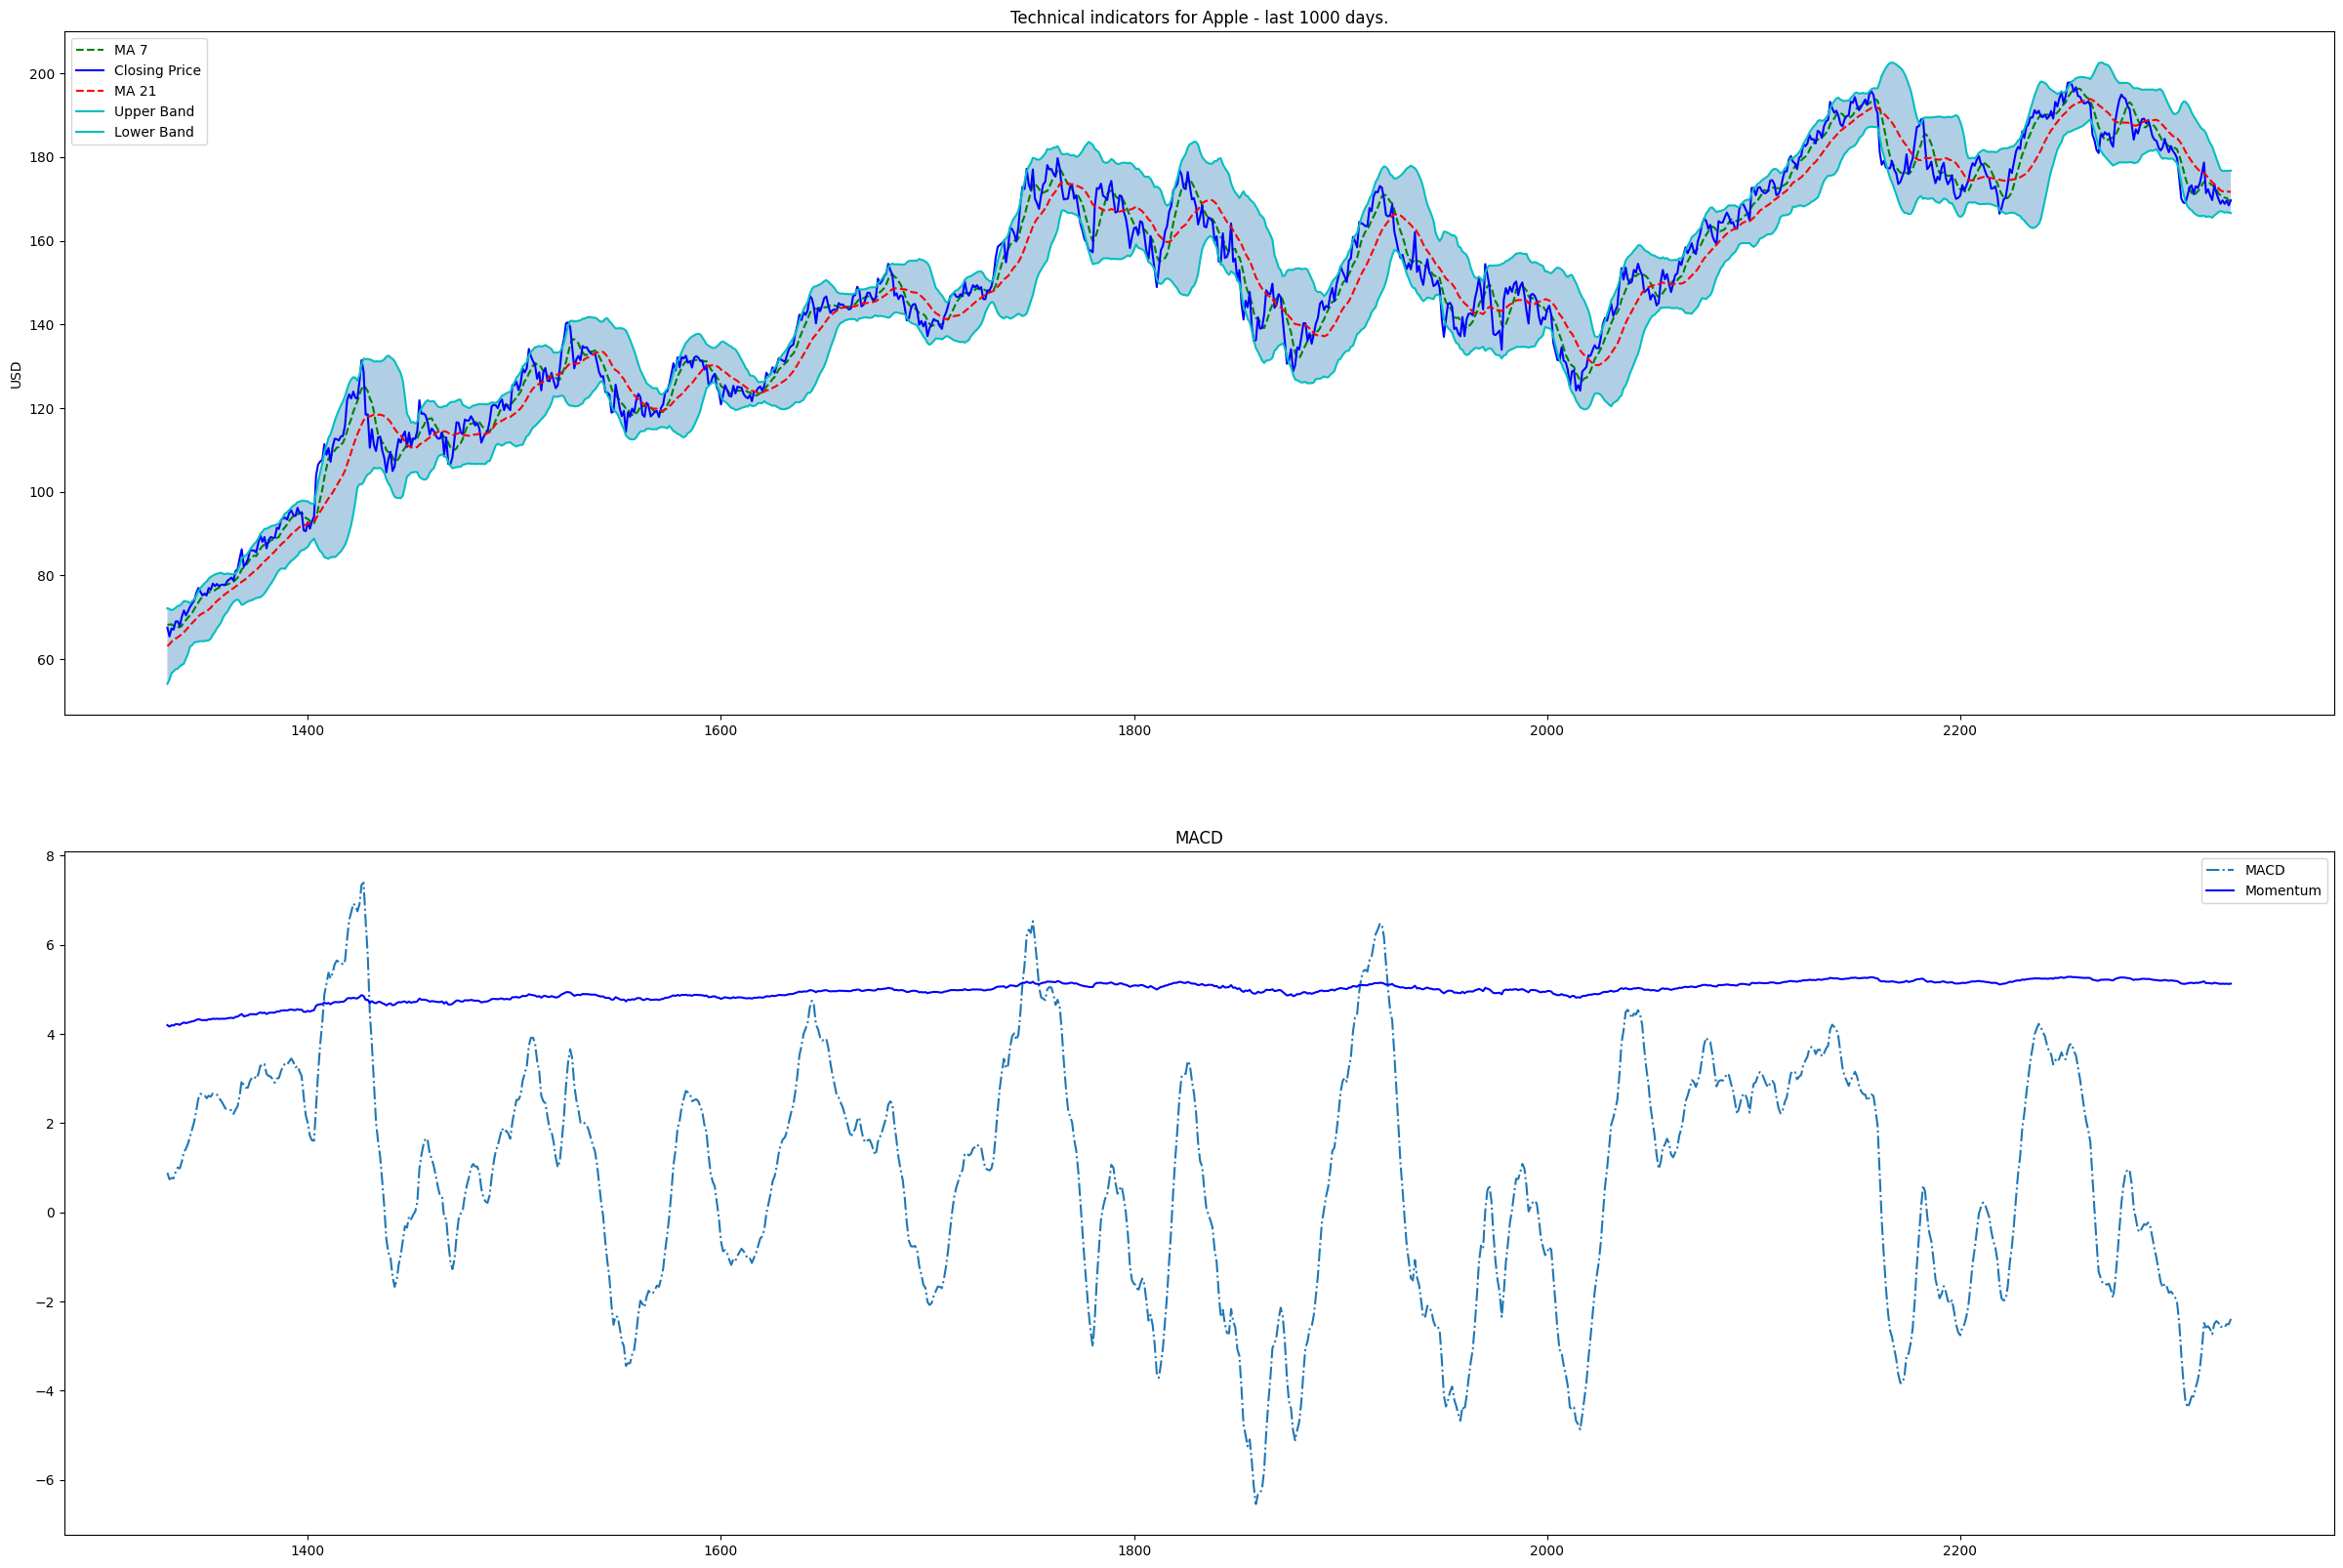

In [16]:
plot_technical_indicators(apple_df, 'Adj Close', 1000, 'Apple')

Text(0.5, 1.0, 'Params')

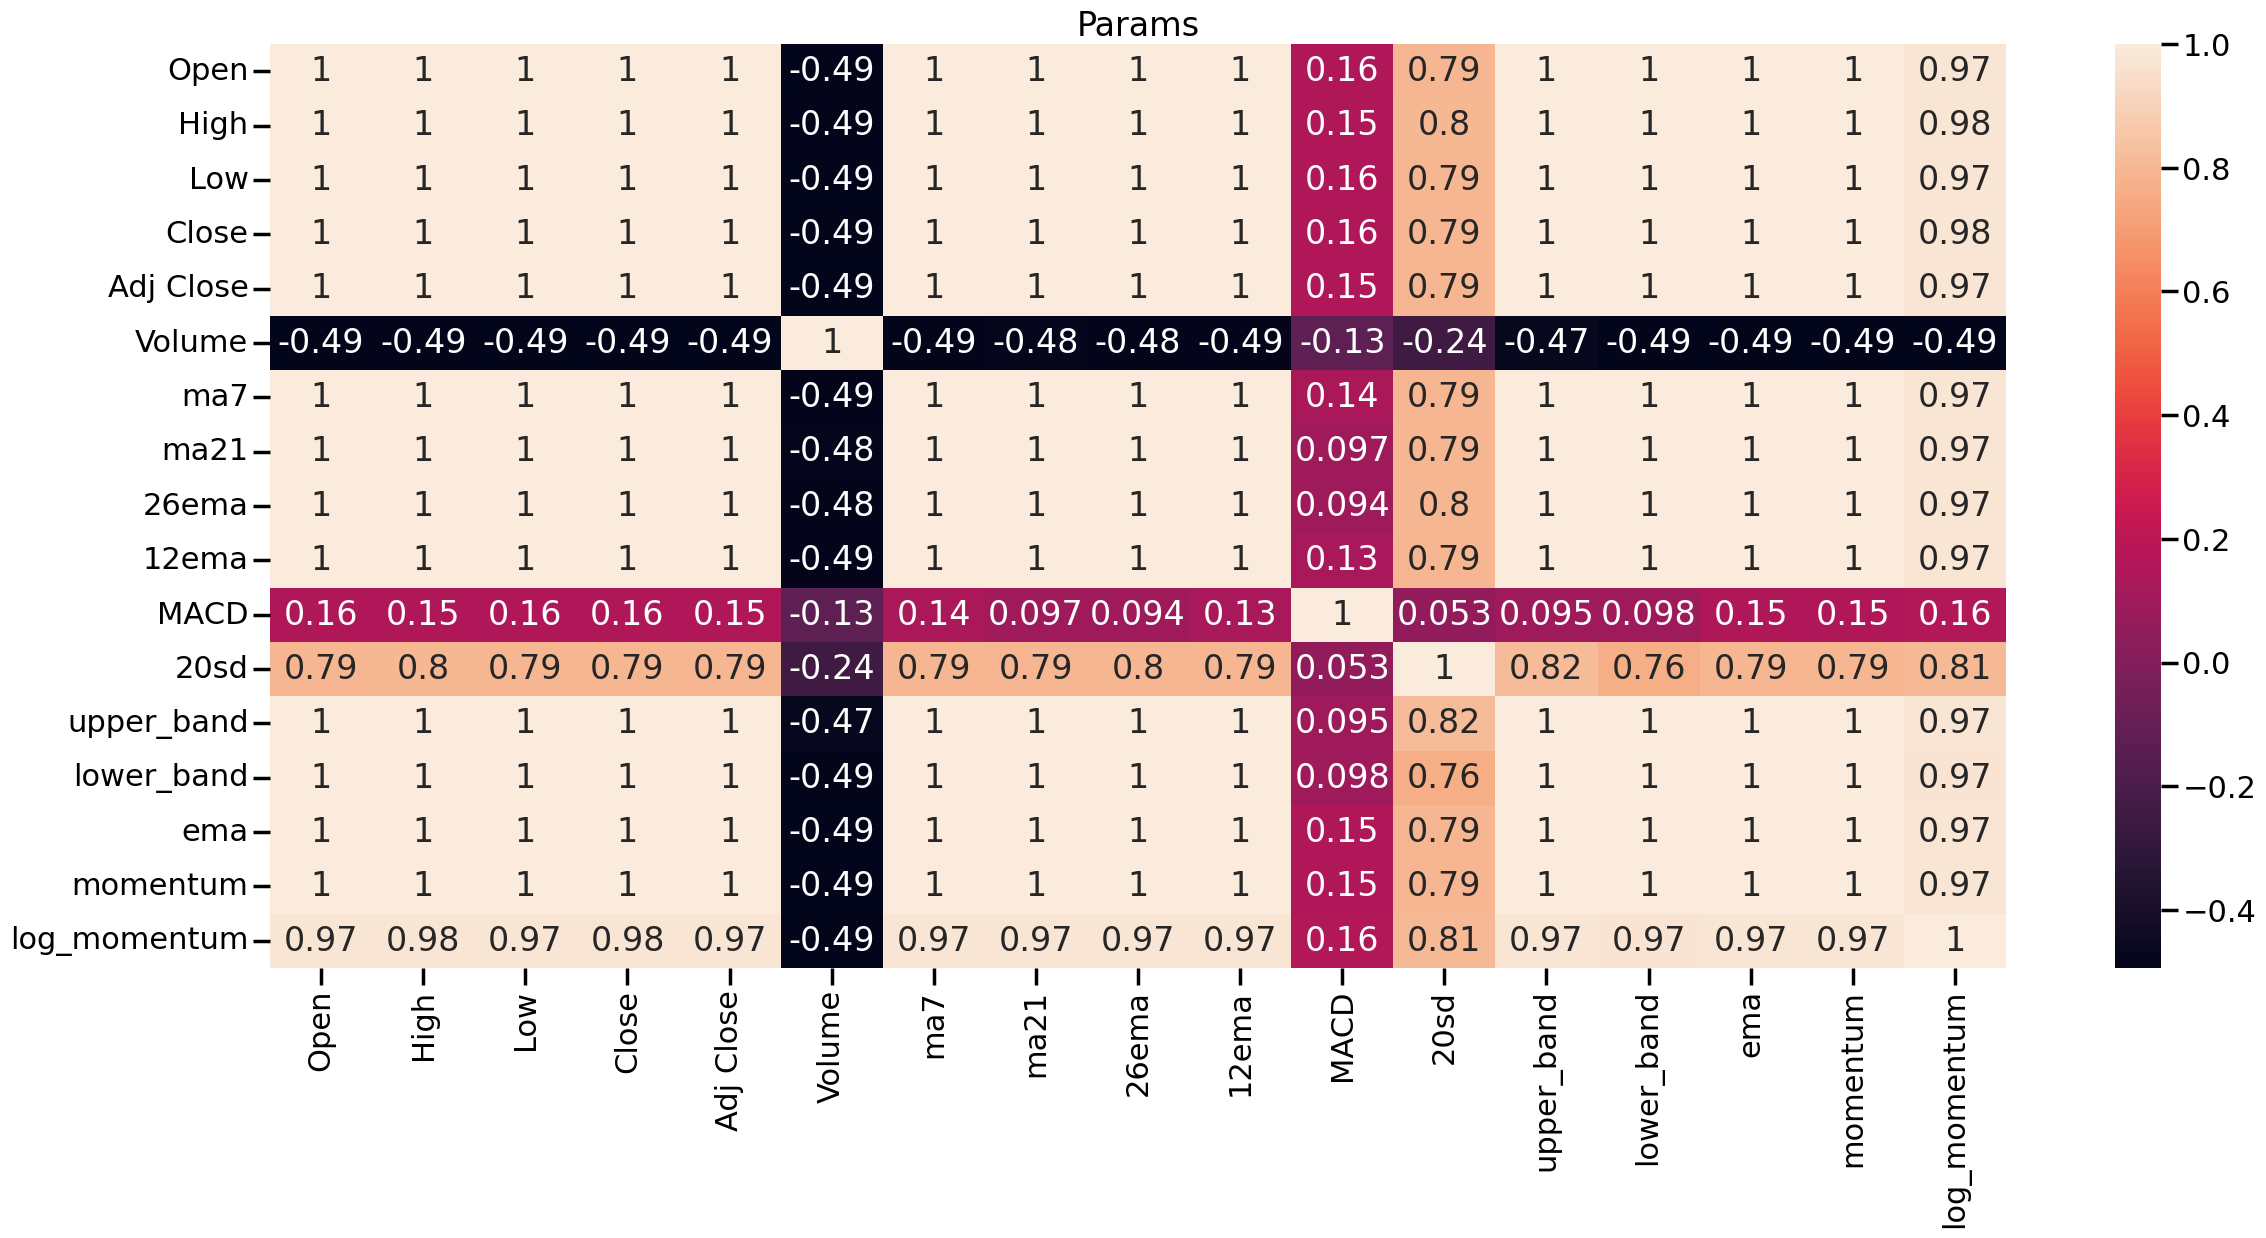

In [17]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(apple_df.drop(columns=['Date','stock_type']).corr(), annot = True).set_title('Params')

### Google Stock Analysis

In [18]:
google_data.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2015-01-02  26.378078  26.490770  26.133251  26.168653  26.168653  28951268
1 2015-01-05  26.091366  26.144720  25.582764  25.623152  25.623152  41196796
2 2015-01-06  25.679497  25.738087  24.983908  25.029282  25.029282  57998800
3 2015-01-07  25.280592  25.292759  24.914099  24.986401  24.986401  41301082
4 2015-01-08  24.831326  25.105074  24.482782  25.065184  25.065184  67071641

In [19]:
google_data.tail()

Date        Open        High         Low       Close   Adj Close  \
2327 2024-04-03  154.919998  156.550003  154.132004  156.369995  156.369995   
2328 2024-04-04  155.080002  156.179993  151.880005  151.940002  151.940002   
2329 2024-04-05  151.679993  154.839996  151.080994  153.940002  153.940002   
2330 2024-04-08  154.014999  156.654999  153.990005  156.139999  156.139999   
2331 2024-04-09  157.350006  159.889999  156.639999  158.139999  158.139999   

        Volume  
2327  17266200  
2328  24184800  
2329  16289800  
2330  16641500  
2331  21521500

In [20]:
google_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [21]:
google_data['stock_type'] = 'GOOG'

In [22]:
# verifying the data if the stock splits have been adjusted
# Google stock split happend to 1:20 ratio on July 18 2022
google_data[(google_data['Date'] < '2022-07-25') & (google_data['Date'] > '2022-07-13')]

Date        Open        High         Low       Close   Adj Close  \
1895 2022-07-14  110.825996  111.987503  109.325500  111.440002  111.440002   
1896 2022-07-15  112.962997  114.000504  111.822502  112.766998  112.766998   
1897 2022-07-18  113.440002  114.800003  109.300003  109.910004  109.910004   
1898 2022-07-19  111.730003  114.809998  110.500000  114.620003  114.620003   
1899 2022-07-20  114.059998  116.330002  113.260002  114.699997  114.699997   
1900 2022-07-21  115.089996  115.209999  111.910004  115.040001  115.040001   
1901 2022-07-22  111.809998  113.180000  107.599998  108.360001  108.360001   

        Volume stock_type  
1895  32366000       GOOG  
1896  34330000       GOOG  
1897  33354000       GOOG  
1898  30992300       GOOG  
1899  26780100       GOOG  
1900  27267800       GOOG  
1901  44455300       GOOG

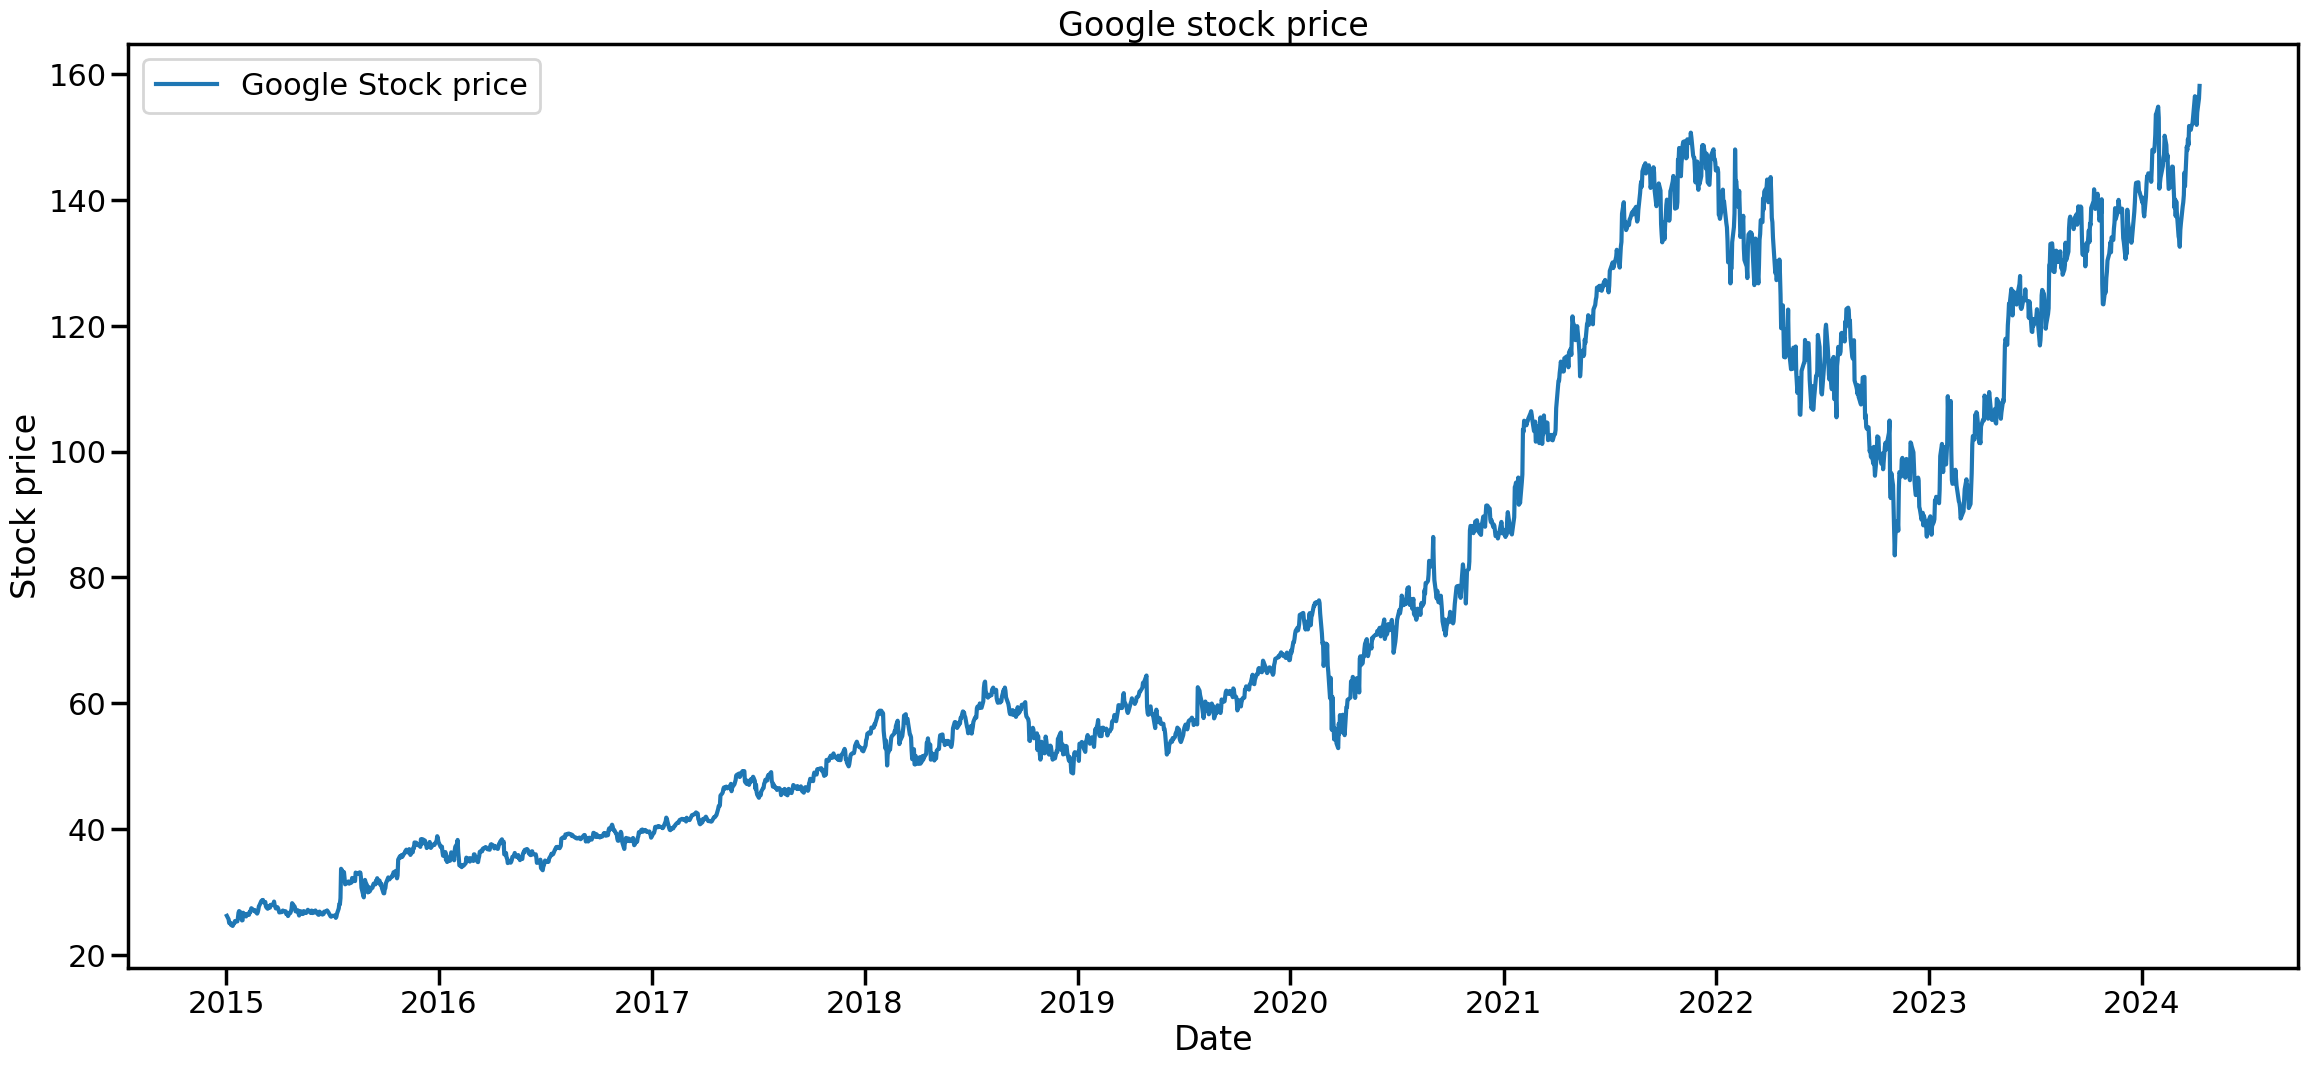

In [23]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(google_data['Date'],google_data['Adj Close'], label='Google Stock price')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.title('Google stock price')
plt.legend()
plt.show()

In [24]:
google_df = get_technical_indicators(google_data, 'Adj Close')

<Figure size 1600x1000 with 0 Axes>

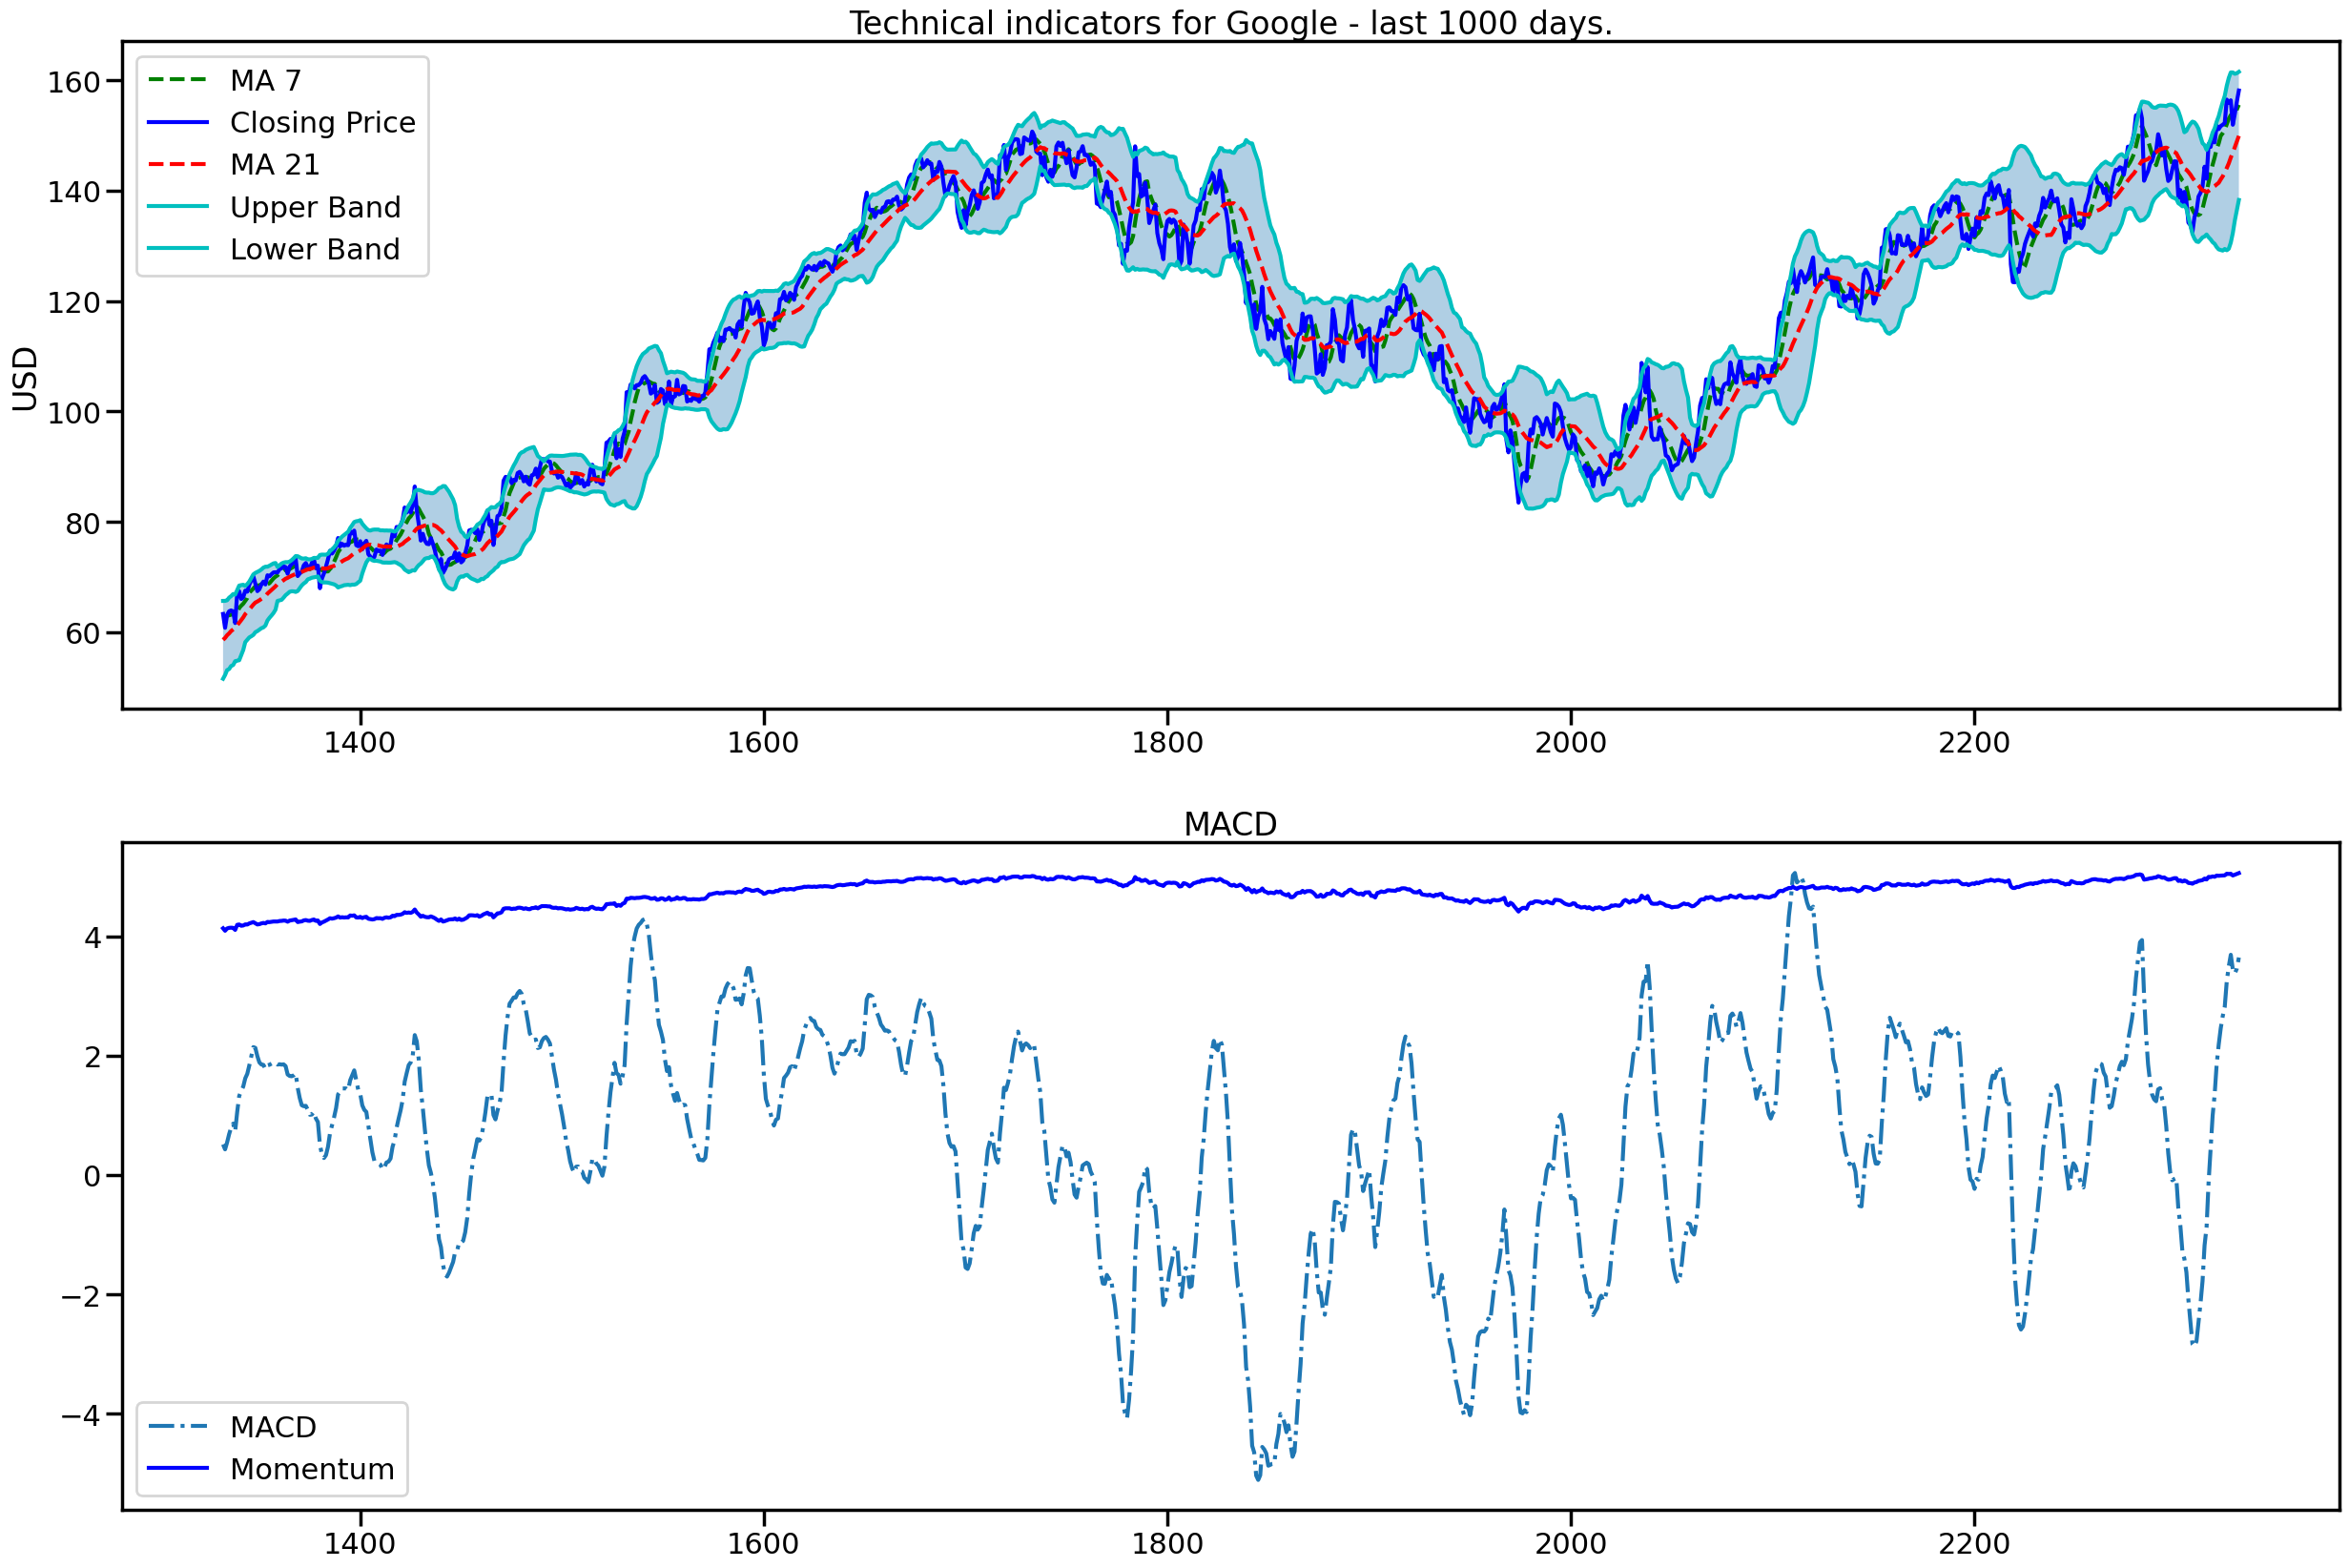

In [25]:
plot_technical_indicators(google_df, 'Adj Close', 1000, 'Google')

Text(0.5, 1.0, 'Params')

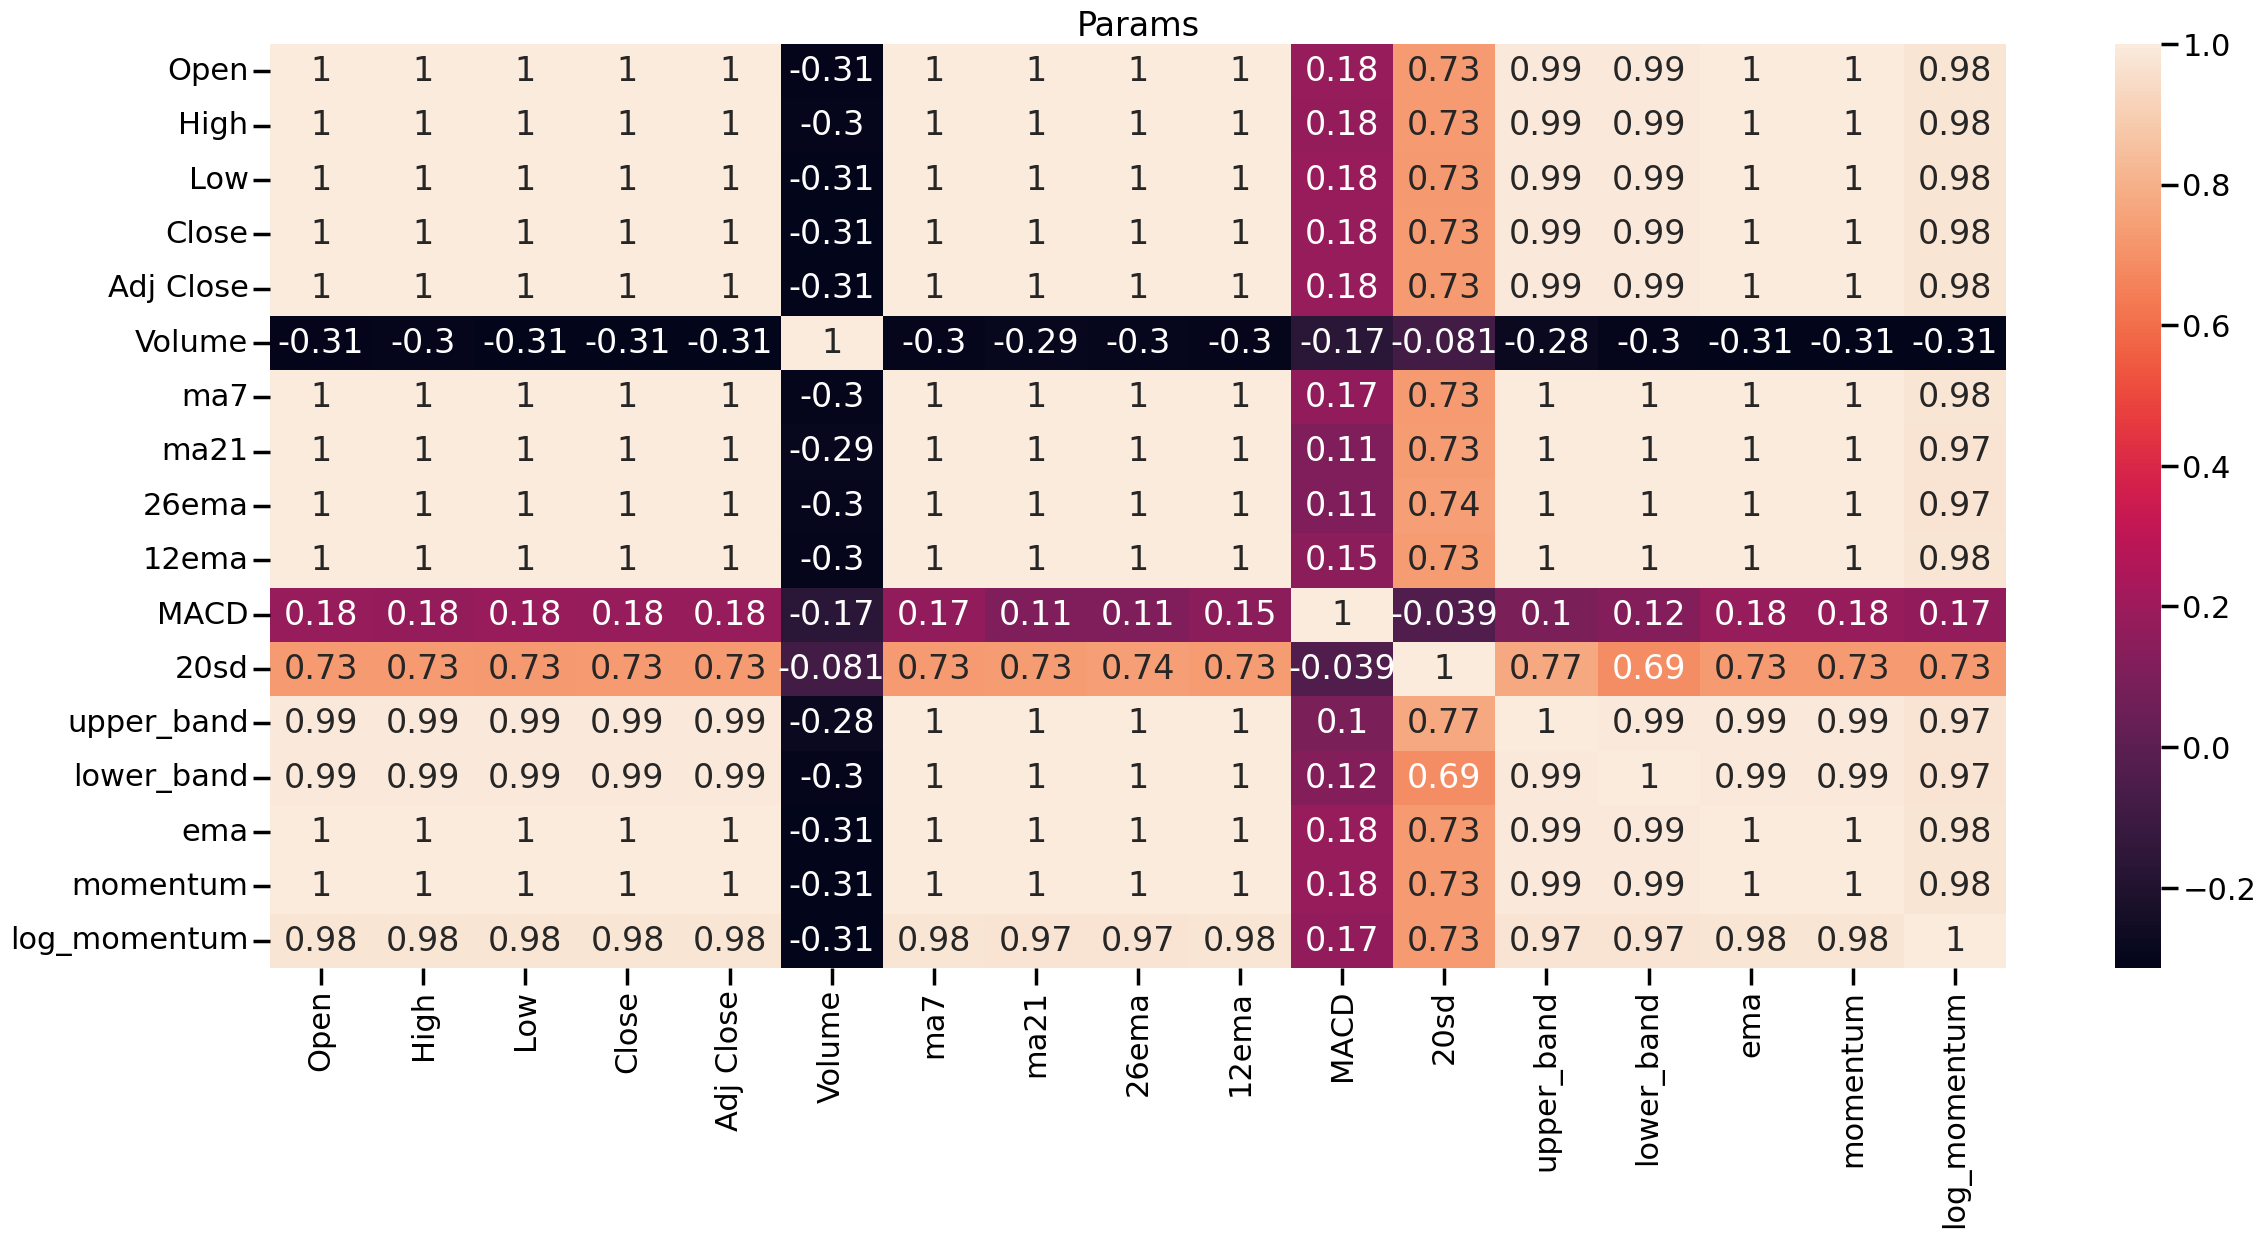

In [26]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(google_df.drop(columns=['Date','stock_type']).corr(), annot = True).set_title('Params')

### Microsoft Stocks Analysis

In [27]:
microsoft_data.head()

Date       Open       High        Low      Close  Adj Close    Volume
0 2015-01-02  46.660000  47.419998  46.540001  46.759998  40.378075  27913900
1 2015-01-05  46.369999  46.730000  46.250000  46.330002  40.006763  39673900
2 2015-01-06  46.380001  46.750000  45.540001  45.650002  39.419567  36447900
3 2015-01-07  45.980000  46.459999  45.490002  46.230000  39.920403  29114100
4 2015-01-08  46.750000  47.750000  46.720001  47.590000  41.094799  29645200

##### No stock splits happend in Microsoft during the period 2015 - 2023

In [28]:
microsoft_data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [29]:
microsoft_data['stock_type'] = 'MSFT'

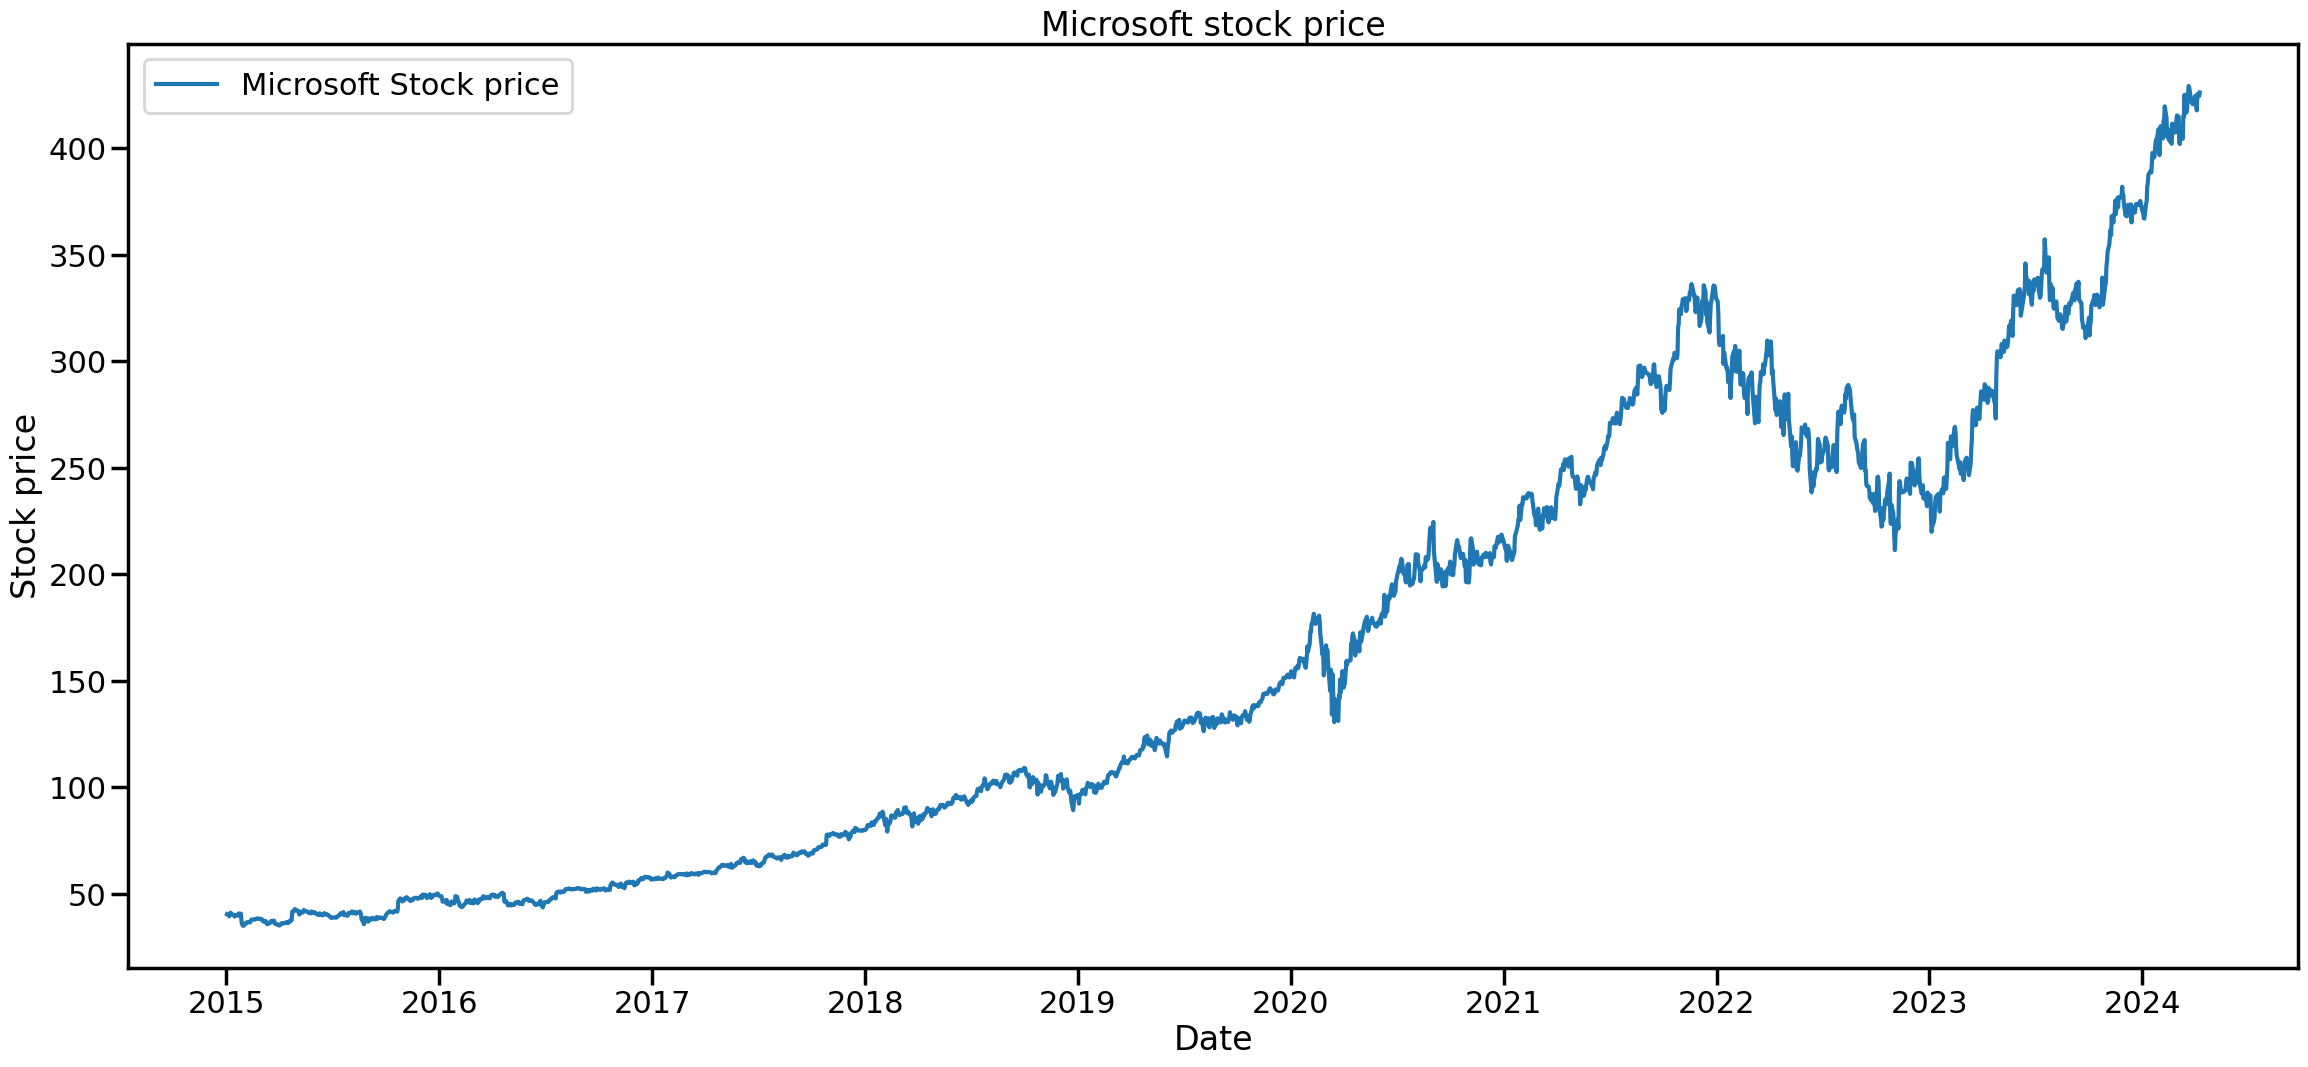

In [30]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(microsoft_data['Date'],microsoft_data['Adj Close'], label='Microsoft Stock price')
plt.xlabel('Date')
plt.ylabel('Stock price')
plt.title('Microsoft stock price')
plt.legend()
plt.show()

In [31]:
microsoft_df = get_technical_indicators(microsoft_data, 'Adj Close')

<Figure size 1600x1000 with 0 Axes>

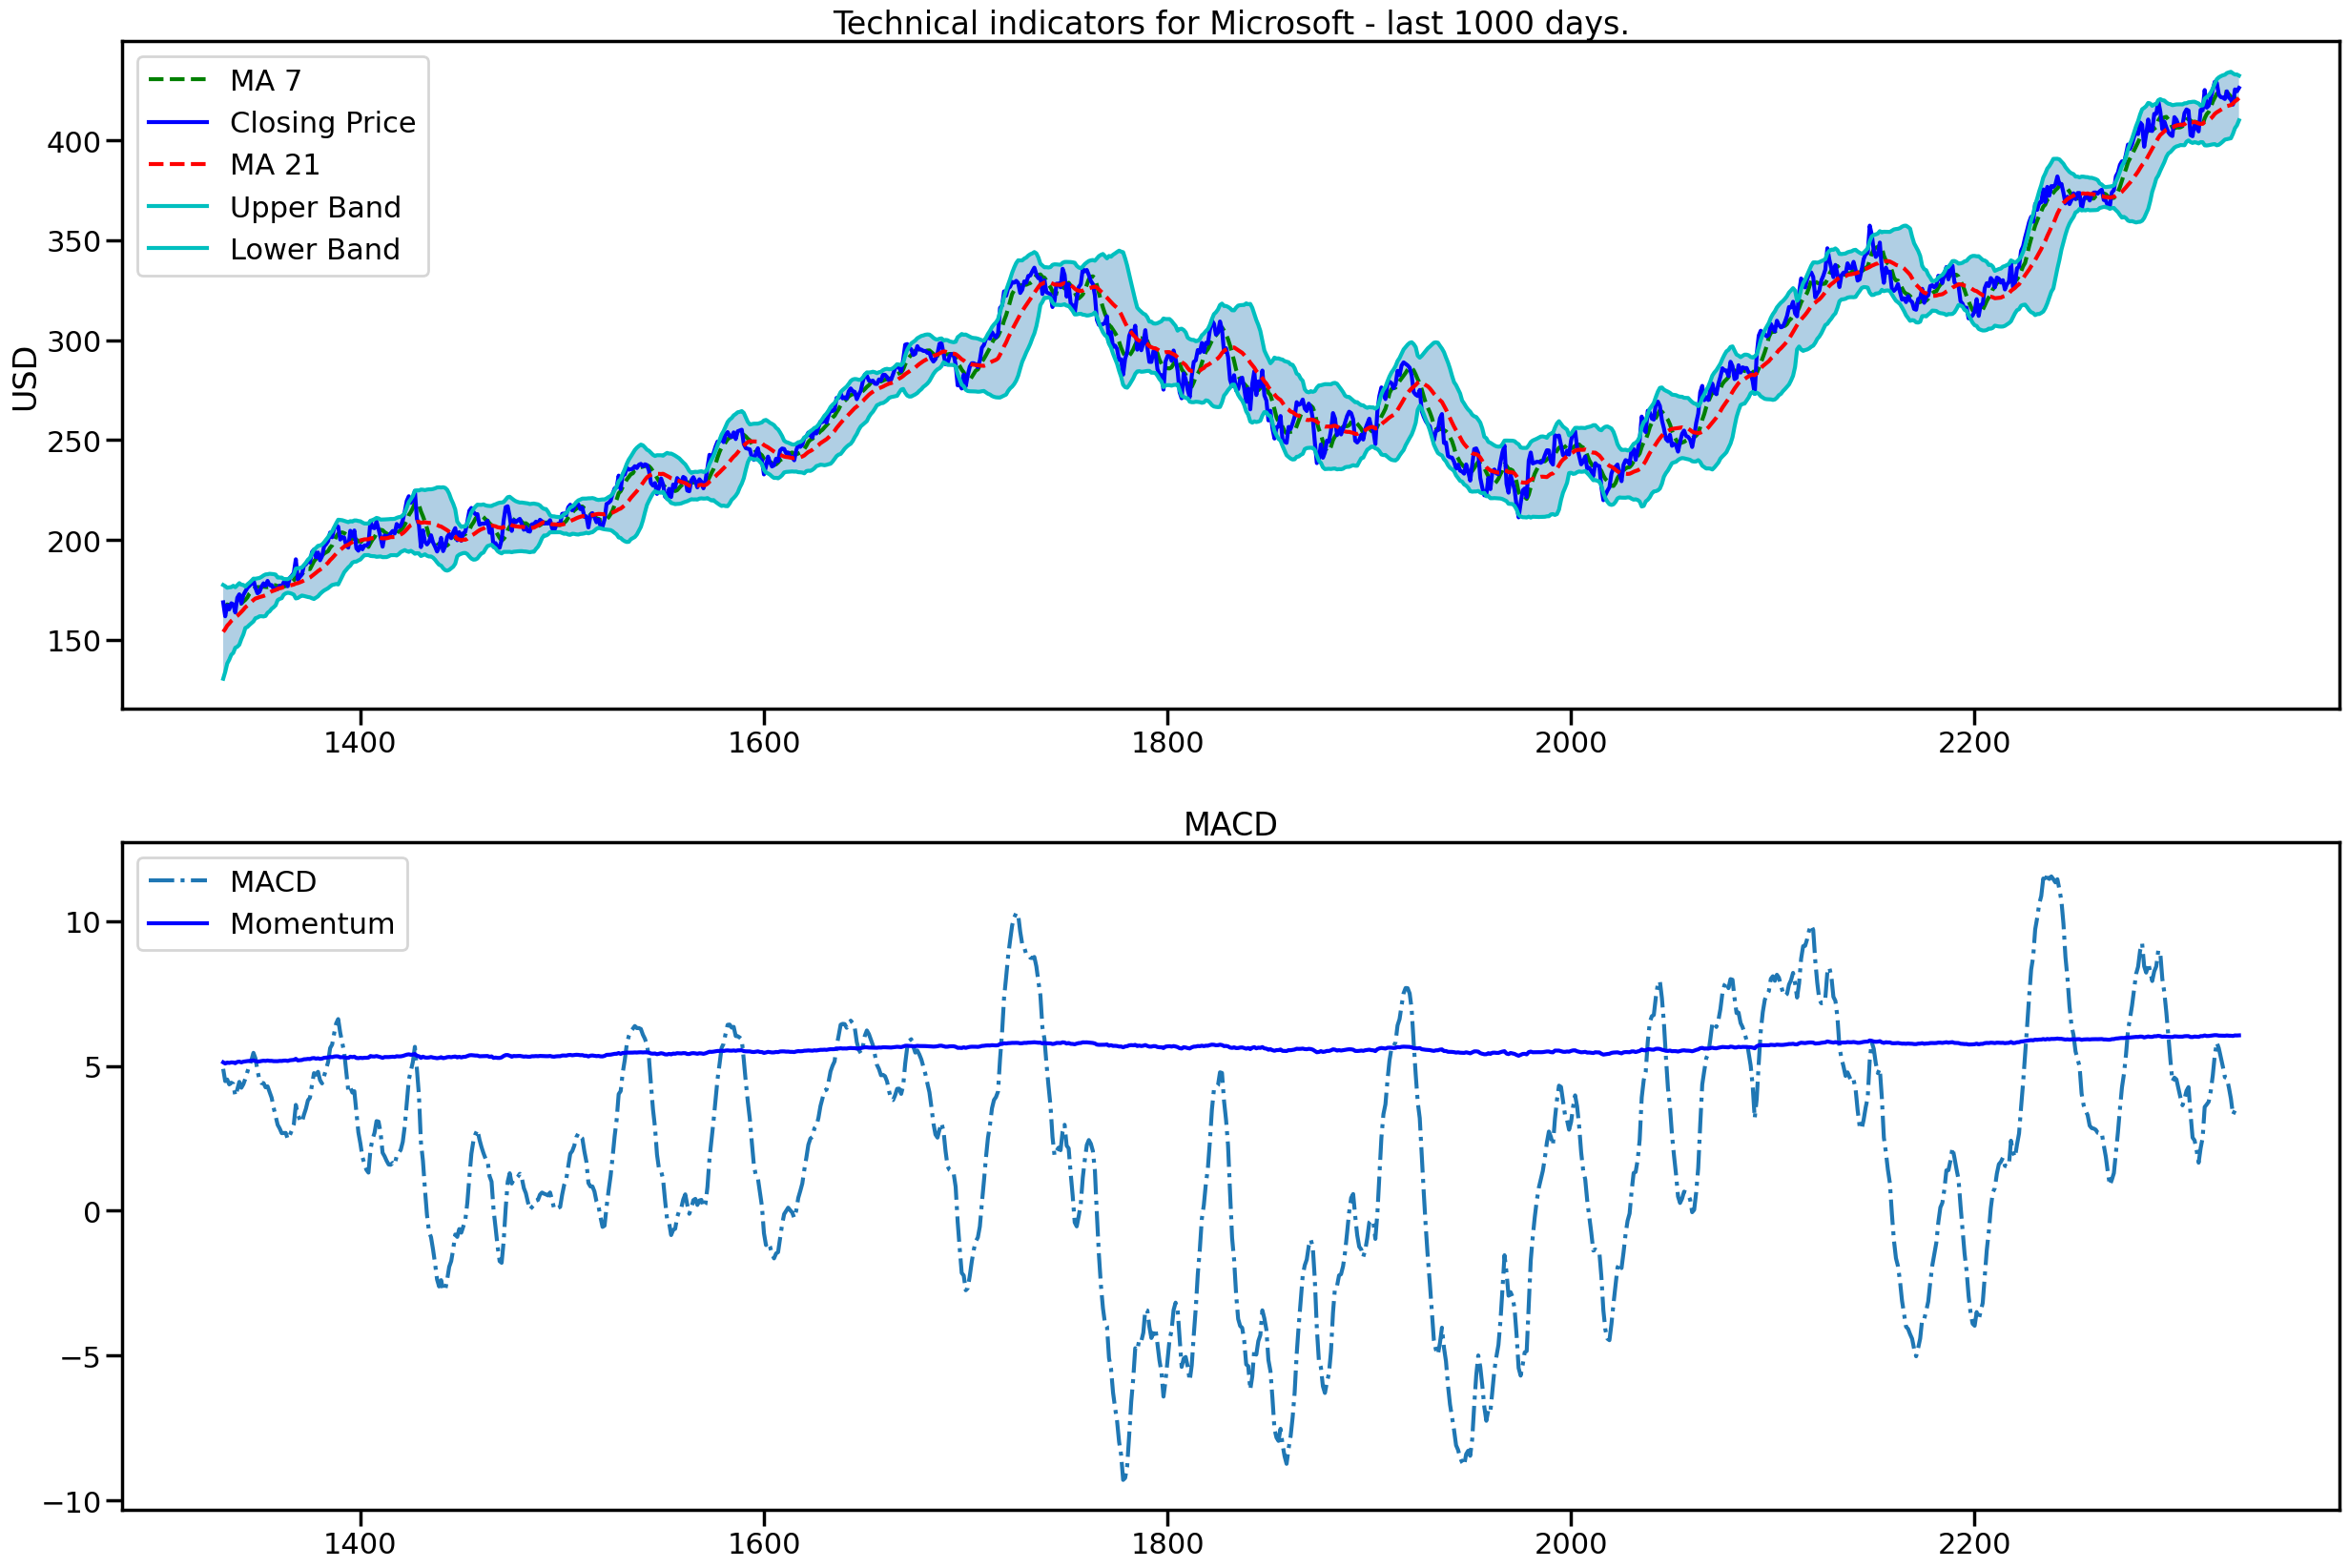

In [32]:
plot_technical_indicators(microsoft_df, 'Adj Close', 1000, 'Microsoft')

Text(0.5, 1.0, 'Params')

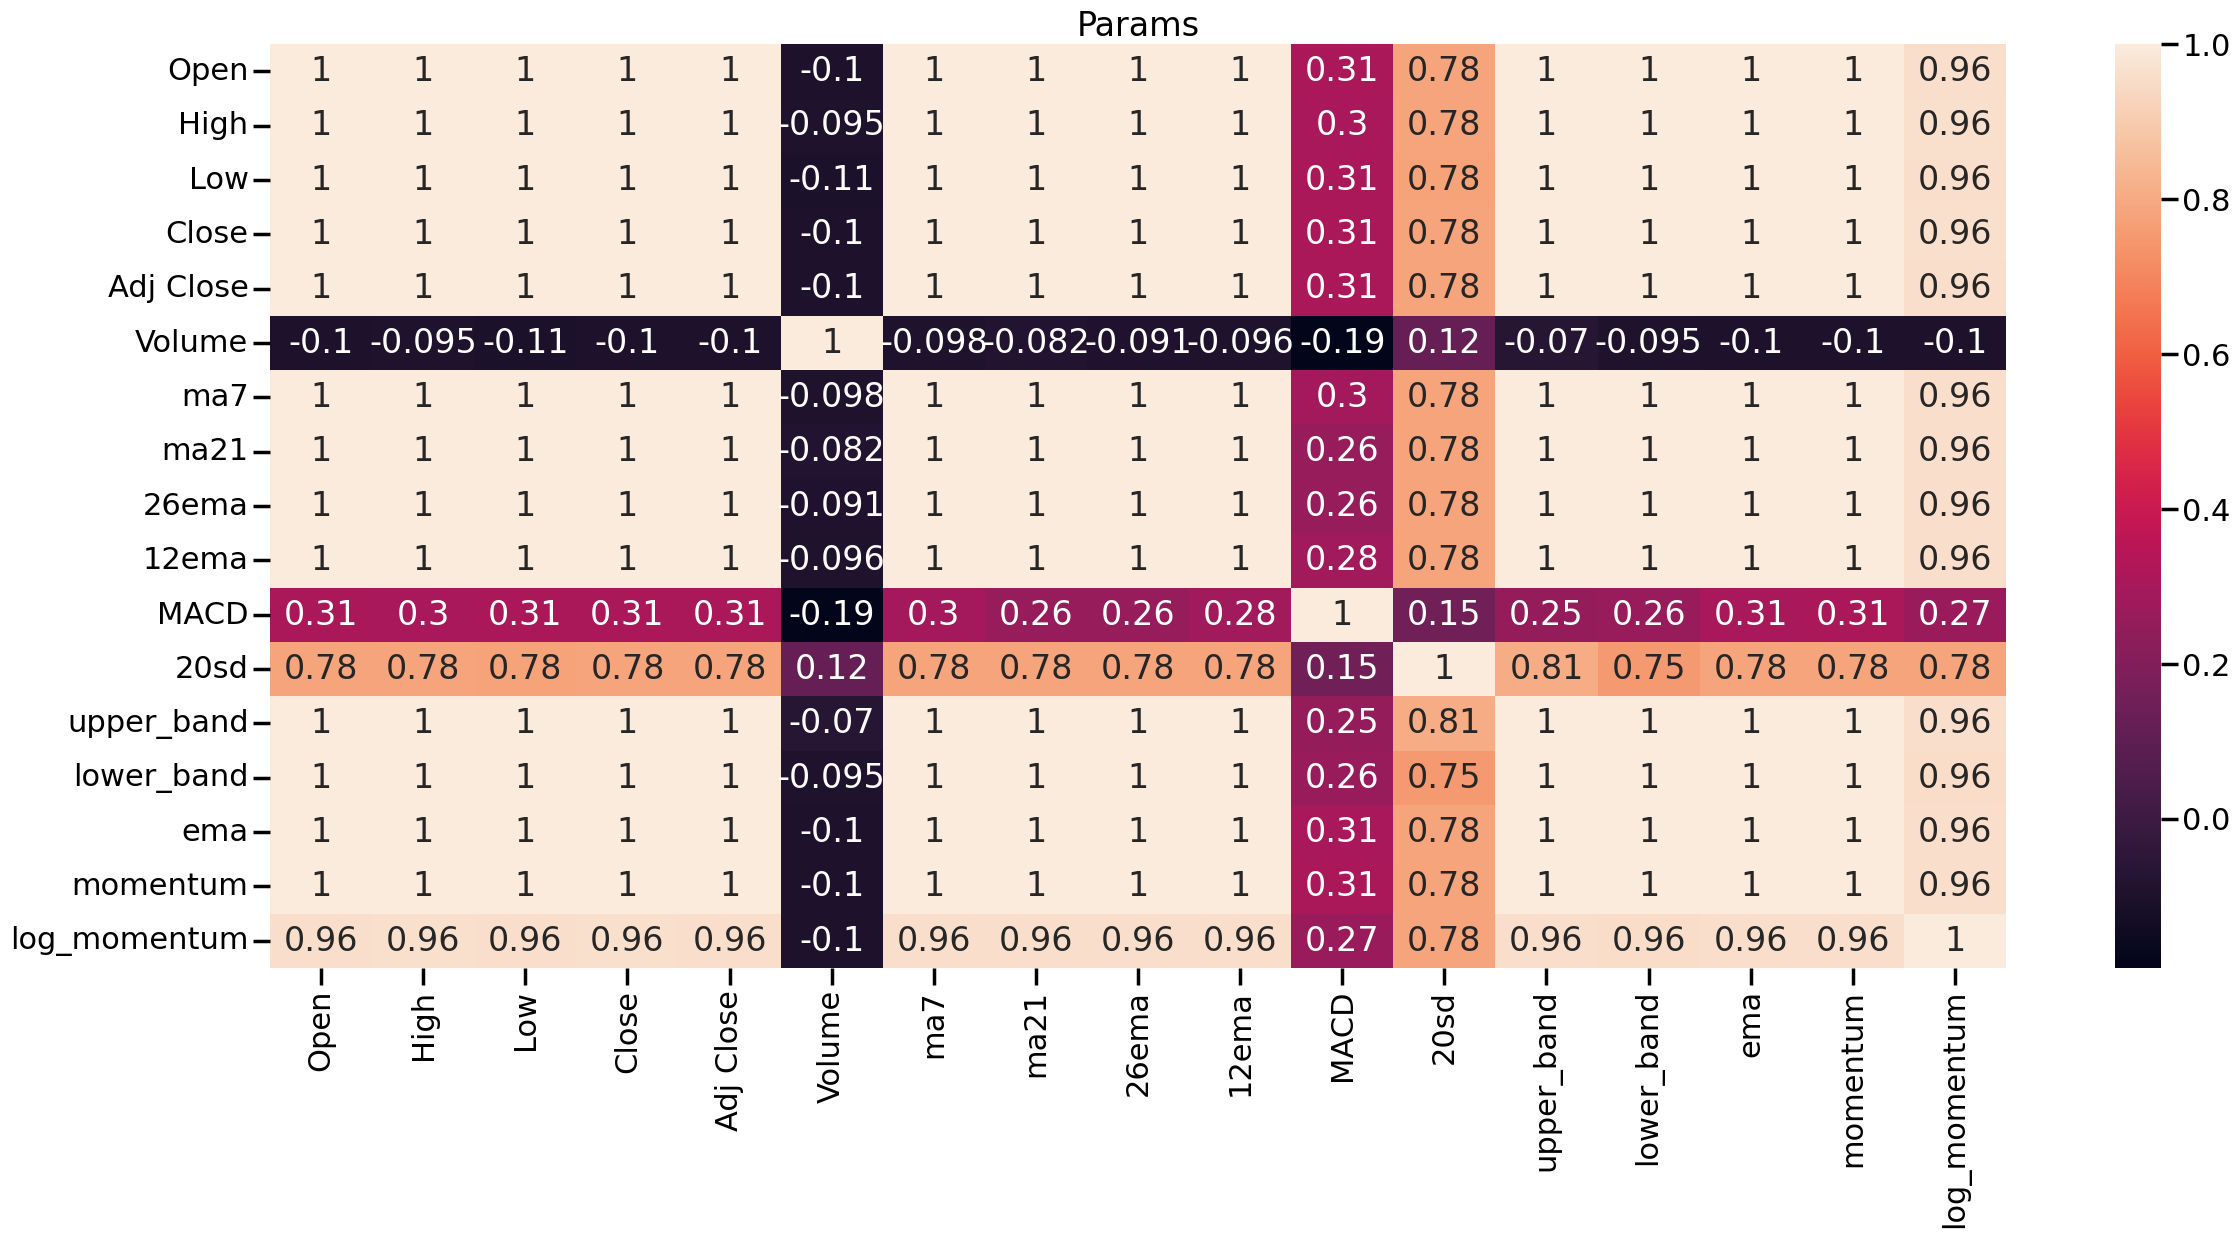

In [33]:
plt.figure(figsize = (28,12))
sns.set_context('poster',font_scale=1)
sns.heatmap(microsoft_df.drop(columns=['Date','stock_type']).corr(), annot = True).set_title('Params')

### Analysis of Google, Amazon and Microsoft stocks

In [34]:
company_list = [apple_df, google_df, microsoft_df]
tech_list = ['Apple', 'Google', 'Microsoft']

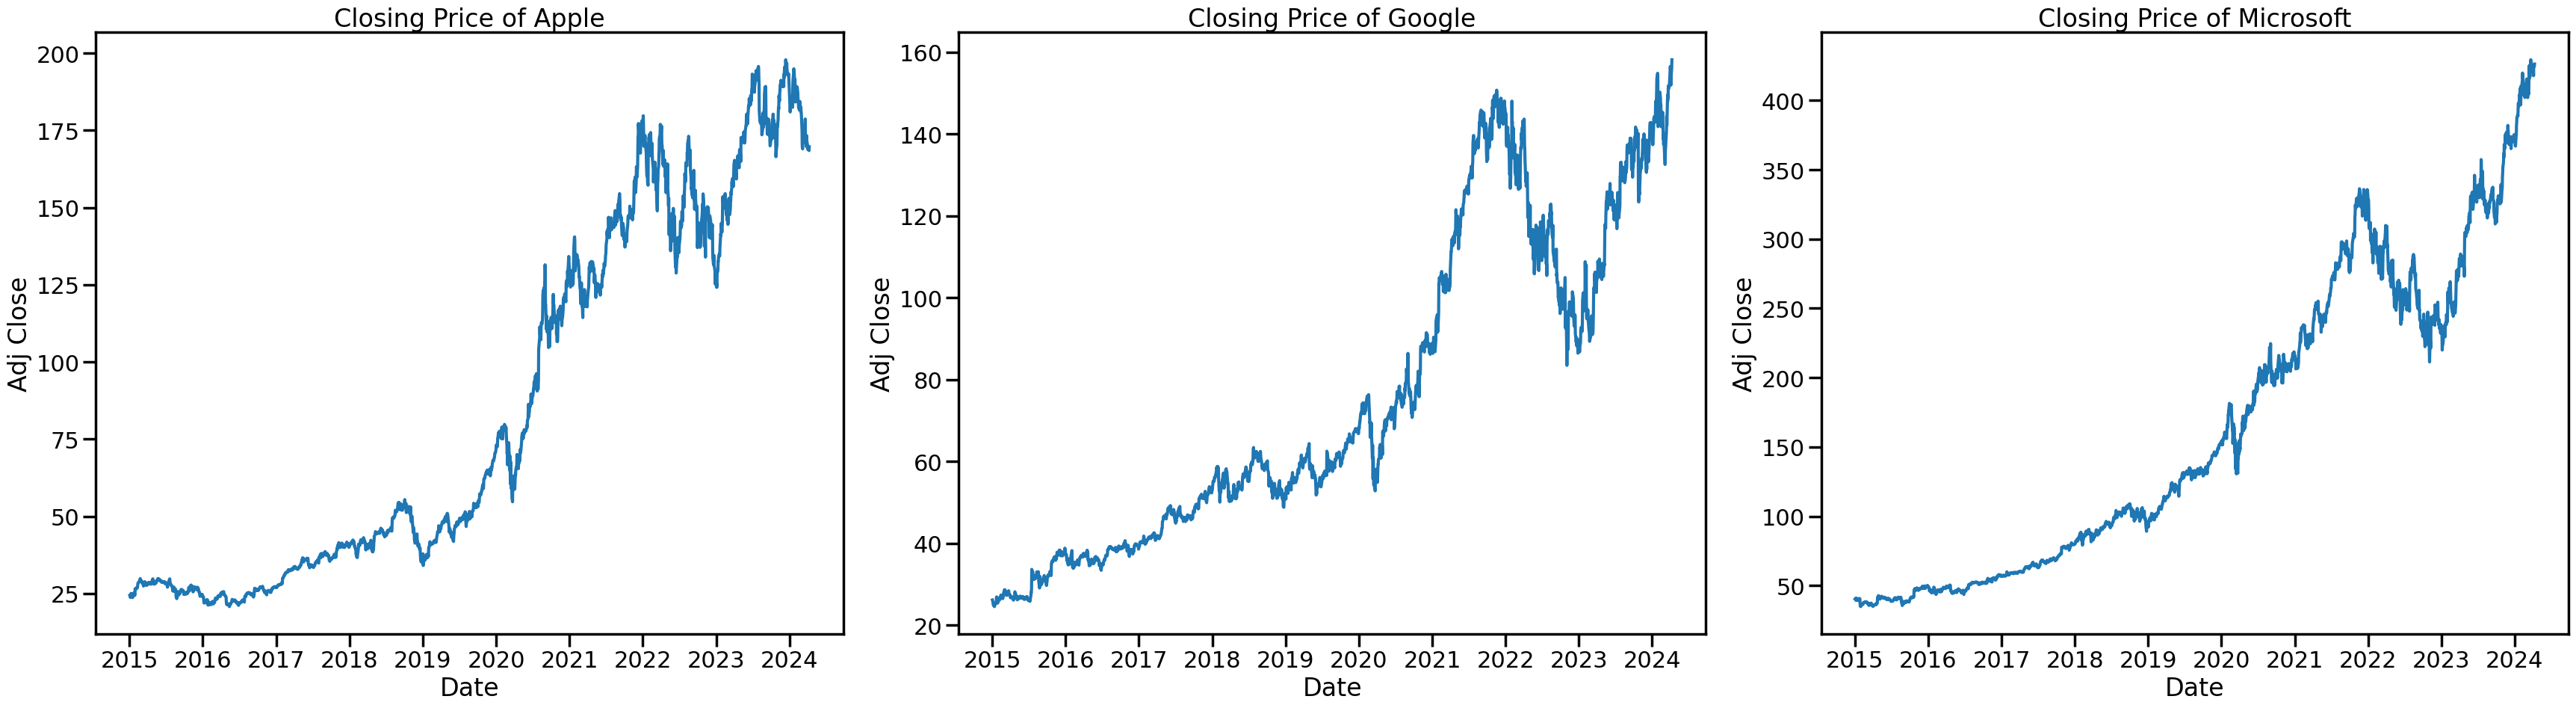

In [35]:
# Let's see a historical view of the closing price
plt.figure(figsize=(35, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(1, 3, i)
    plt.plot(company['Date'], company['Adj Close'])
#     company['Adj Close'].plot()
    plt.ylabel('Adj Close')
    plt.xlabel('Date')
    plt.title(f"Closing Price of {tech_list[i - 1]}")
    
plt.tight_layout()

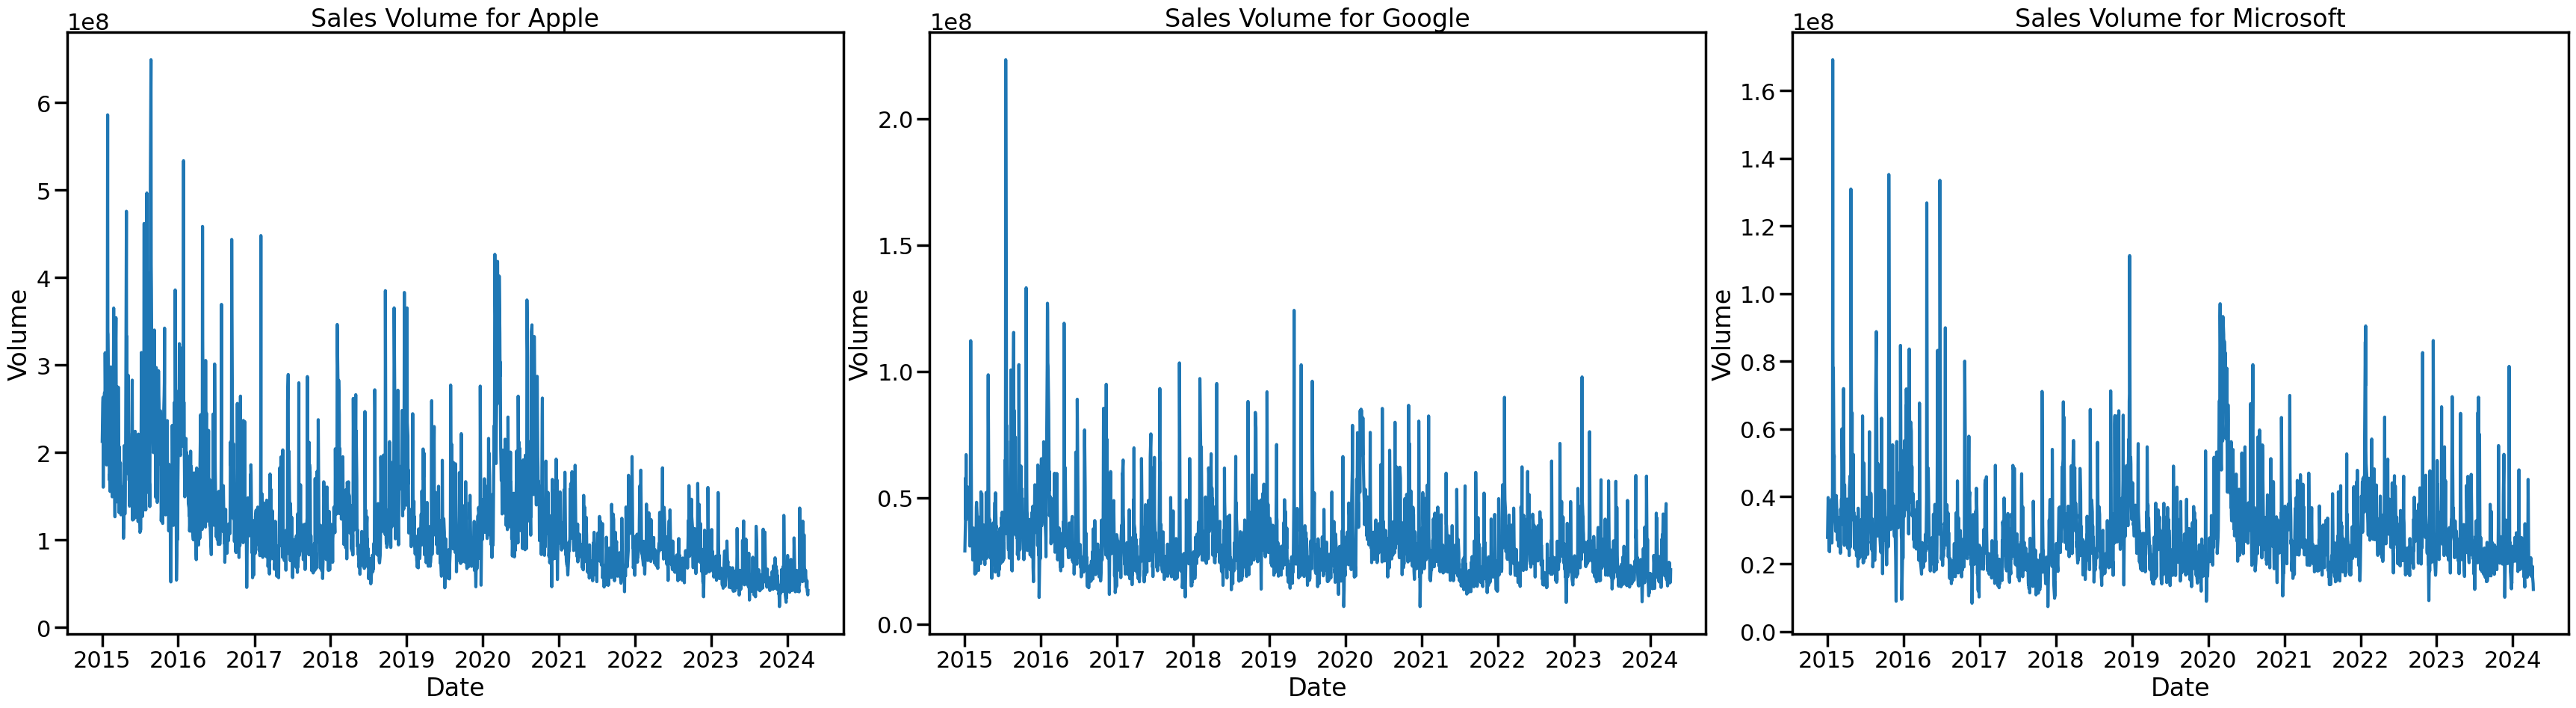

In [36]:
# Now let's plot the total volume of stock being traded each day
# we can see the slight decreasing trend in volume of stocks traded
plt.figure(figsize=(35, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(company_list, 1):
    plt.subplot(1, 3, i)
    plt.plot(company['Date'], company['Volume'])
    plt.ylabel('Volume')
    plt.xlabel('Date')
    plt.title(f"Sales Volume for {tech_list[i - 1]}")
    
plt.tight_layout()

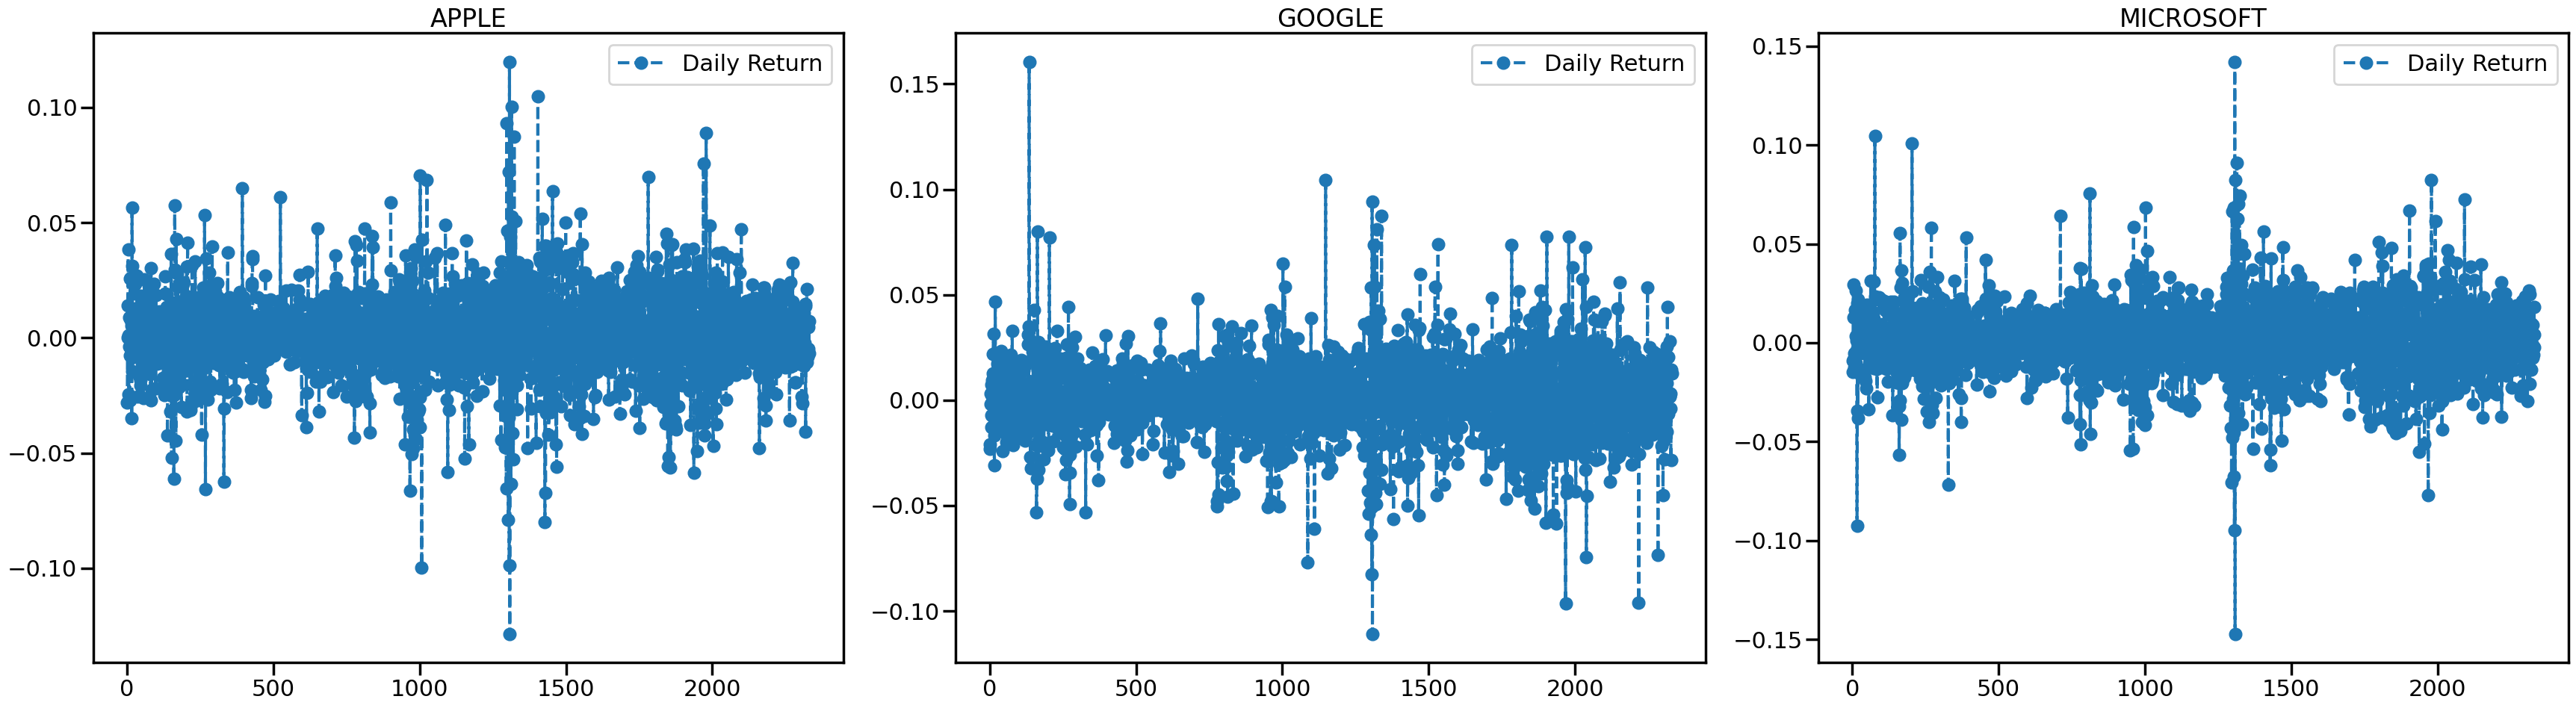

In [37]:
# We'll use pct_change to find the percent change for each day
for company in company_list:
    company['Daily Return'] = company['Adj Close'].pct_change()

# Then we'll plot the daily return percentage
fig, axes = plt.subplots(nrows=1, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(35)

apple_df['Daily Return'].plot(ax=axes[0], legend=True, linestyle='--', marker='o')
axes[0].set_title('APPLE')

google_df['Daily Return'].plot(ax=axes[1], legend=True, linestyle='--', marker='o')
axes[1].set_title('GOOGLE')

microsoft_df['Daily Return'].plot(ax=axes[2], legend=True, linestyle='--', marker='o')
axes[2].set_title('MICROSOFT')

fig.tight_layout()

### LSTM models for each stock

##### Apple stock prediction model

In [38]:
apple_df = apple_df.dropna()

In [39]:
apple_df.head()

Date       Open       High        Low      Close  Adj Close  \
20 2015-02-02  29.512501  29.792500  29.020000  29.657499  26.513821   
21 2015-02-03  29.625000  29.772499  29.402500  29.662500  26.518295   
22 2015-02-04  29.625000  30.127501  29.577499  29.889999  26.721678   
23 2015-02-05  30.004999  30.057501  29.812500  29.985001  26.912403   
24 2015-02-06  30.004999  30.062500  29.612499  29.732500  26.685776   

       Volume stock_type        ma7       ma21      26ema      12ema  \
20  250956400       AAPL  25.709540  24.813411  25.124878  25.474018   
21  207662800       AAPL  25.890576  24.912602  25.251359  25.638854   
22  280598800       AAPL  26.096835  25.054259  25.382629  25.809093   
23  168984800       AAPL  26.456778  25.204891  25.517161  25.981970   
24  174826400       AAPL  26.587345  25.328873  25.618527  26.091936   

        MACD      20sd  upper_band  lower_band        ema   momentum  \
20  0.349140  0.874321   26.562052   23.064769  26.404206  25.513821   
21  0.387494  0.944610   26.801822   23.023383  26.480266  25.518295   
22  0.426464  0.983317   27.020892   23.087625  26.641207  25.721678   
23  0.464809  1.015162   27.235215   23.174567  26.822004  25.912403   
24  0.473410  1.030066   27.389005   23.268742  26.731185  25.685776   

    log_momentum  Daily Return  
20      3.239220      0.012547  
21      3.239396      0.000169  
22      3.247334      0.007670  
23      3.254722      0.007137  
24      3.245937     -0.008421

In [40]:
apple_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'stock_type', 'ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return'],
      dtype='object')

In [41]:
apple_data_training = apple_df[apple_df['Date'] <= '2022-12-31'].copy()
apple_data_testing = apple_df[apple_df['Date'] > '2022-12-31'].copy()

In [42]:
apple_data_training = apple_data_training[['Adj Close','Open', 'High', 'Low','Volume','ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return']]
apple_data_testing = apple_data_testing[['Adj Close','Open', 'High', 'Low','Volume','ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return']]

In [43]:
apple_scalar = MinMaxScaler()

apple_data_training_scaled = apple_scalar.fit_transform(apple_data_training)
print(apple_data_training_scaled.shape)
apple_data_training_scaled

(1994, 17)


array([[0.03612192, 0.04379255, 0.04296271, ..., 0.03612192, 0.11580171,
        0.56828687],
       [0.03615007, 0.0444951 , 0.04283772, ..., 0.03615007, 0.11588136,
        0.51846669],
       [0.03742959, 0.0444951 , 0.04505617, ..., 0.03742959, 0.11948718,
        0.54865624],
       ...,
       [0.65684771, 0.66926869, 0.6756081 , ..., 0.65684771, 0.83461071,
        0.39428347],
       [0.67915395, 0.65877721, 0.67217106, ..., 0.67915395, 0.84739812,
        0.63178923],
       [0.68115326, 0.66140012, 0.66885904, ..., 0.68115326, 0.84852687,
        0.52772396]])

In [44]:
apple_X_train = []
apple_y_train = []

In [45]:
for i in range(60, apple_data_training.shape[0]):
    apple_X_train.append(apple_data_training_scaled[i-60: i, 1:])
    apple_y_train.append(apple_data_training_scaled[i, 0])

In [46]:
apple_X_train, apple_y_train = np.array(apple_X_train), np.array(apple_y_train)
apple_X_train.shape, apple_y_train.shape

((1934, 60, 16), (1934,))

In [47]:
def create_model(X_train):
    regressor = Sequential()

    regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 16)))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    regressor.add(Dropout(0.3))

    regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
    regressor.add(Dropout(0.4))

    regressor.add(LSTM(units = 120, activation = 'relu'))
    regressor.add(Dropout(0.5))

    regressor.add(Dense(units = 1))
    return regressor

In [48]:
# Compiling the RNN
apple_regressor = create_model(apple_X_train)
apple_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [49]:
apple_regressor.fit(apple_X_train, apple_y_train, epochs=50, batch_size = 64)

Epoch 1/50
31/31 [==============================] - 13s 203ms/step - loss: 0.0317
Epoch 2/50
31/31 [==============================] - 6s 209ms/step - loss: 0.0078
Epoch 3/50
31/31 [==============================] - 6s 204ms/step - loss: 0.0082
Epoch 4/50
31/31 [==============================] - 6s 202ms/step - loss: 0.0078
Epoch 5/50
31/31 [==============================] - 6s 198ms/step - loss: 0.0073
Epoch 6/50
31/31 [==============================] - 6s 200ms/step - loss: 0.0063
Epoch 7/50
31/31 [==============================] - 7s 212ms/step - loss: 0.0064
Epoch 8/50
31/31 [==============================] - 6s 199ms/step - loss: 0.0066
Epoch 9/50
31/31 [==============================] - 6s 198ms/step - loss: 0.0053
Epoch 10/50
31/31 [==============================] - 6s 199ms/step - loss: 0.0050
Epoch 11/50
31/31 [==============================] - 6s 200ms/step - loss: 0.0056
Epoch 12/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0056
Epoch 13/50
31/31 [=====

In [50]:
apple_past_60 = apple_data_training.tail(60)

apple_dt = pd.concat([apple_past_60, apple_data_testing], axis=0)

In [51]:
apple_inputs = apple_scalar.fit_transform(apple_dt)
print(apple_inputs.shape)
apple_inputs

(378, 17)


array([[0.27183136, 0.27496174, 0.27515654, ..., 0.27183136, 0.32134247,
        0.30216092],
       [0.19998029, 0.22955132, 0.21336131, ..., 0.19998029, 0.24099984,
        0.08249457],
       [0.20442038, 0.20011103, 0.19652057, ..., 0.20442038, 0.24605339,
        0.3677197 ],
       ...,
       [0.61626834, 0.60519362, 0.59318029, ..., 0.61626834, 0.66931981,
        0.38338639],
       [0.60093395, 0.59741696, 0.57661797, ..., 0.60093395, 0.65497764,
        0.30188416],
       [0.6174896 , 0.59283424, 0.58886578, ..., 0.6174896 , 0.67045792,
        0.40339238]])

In [52]:
apple_X_test = []
apple_y_test = []

for i in range(60, apple_inputs.shape[0]):
    apple_X_test.append(apple_inputs[i-60:i, 1:])
    apple_y_test.append(apple_inputs[i, 0])
    
apple_X_test, apple_y_test = np.array(apple_X_test), np.array(apple_y_test)
apple_X_test.shape, apple_y_test.shape

((318, 60, 16), (318,))

In [53]:
y_pred = apple_regressor.predict(apple_X_test)

10/10 [==============================] - 1s 43ms/step


In [54]:
scale = 1/apple_scalar.scale_[0]

In [55]:
y_pred = y_pred*scale
apple_y_test = apple_y_test*scale

In [56]:
from sklearn.metrics import r2_score
r2_score(apple_y_test, y_pred)

0.5034652696239308

#### R2 : 0.825

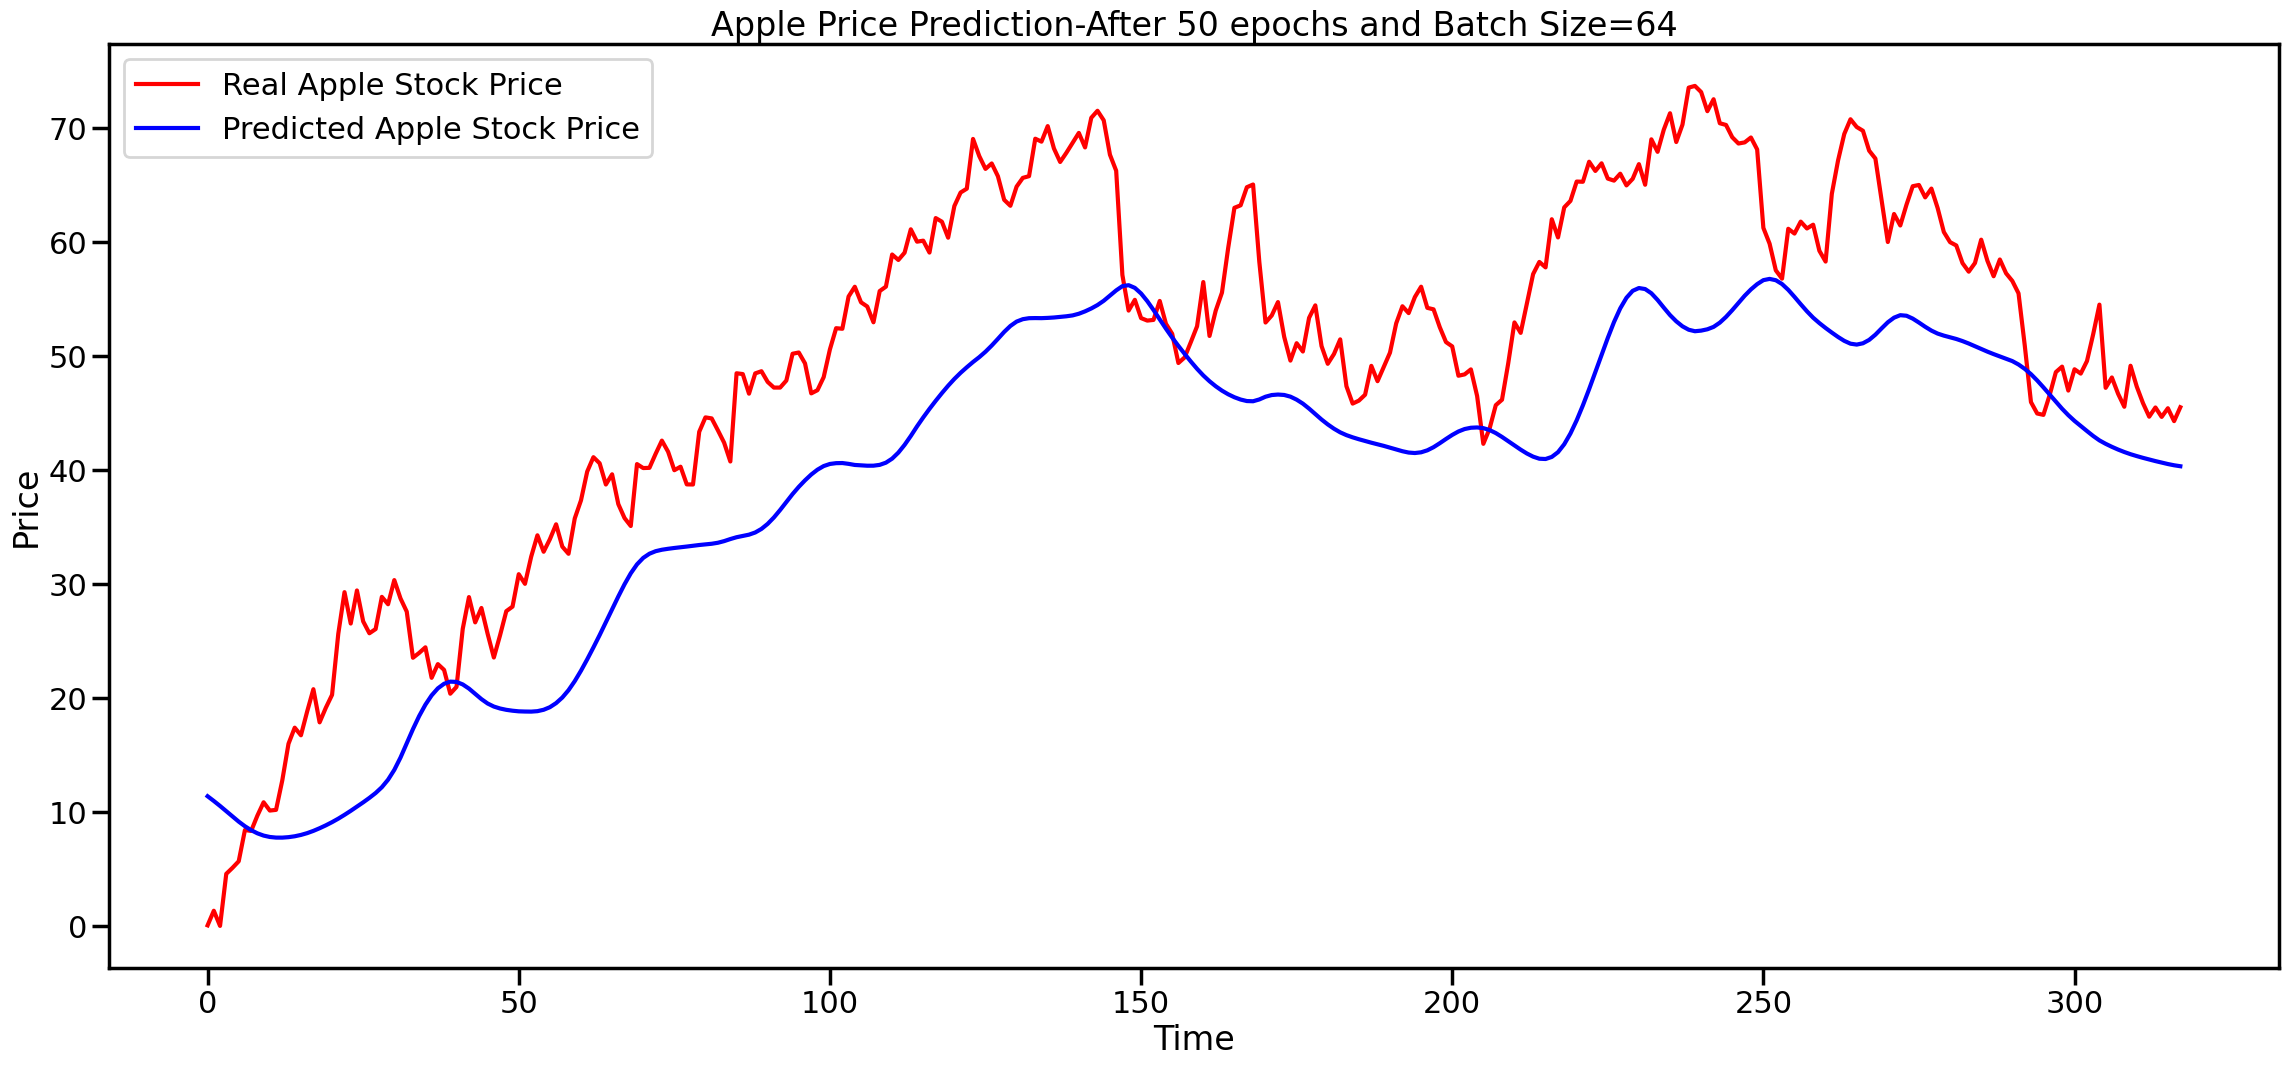

In [57]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(apple_y_test, color = 'red', label = 'Real Apple Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Apple Stock Price')
plt.title('Apple Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

##### Google Stock price prediction

In [58]:
google_df = google_df.dropna()

In [59]:
google_data_training = google_df[google_df['Date'] <= '2022-12-31'].copy()
google_data_testing = google_df[google_df['Date'] > '2022-12-31'].copy()

In [60]:
google_data_training = google_data_training[['Adj Close','Open', 'High', 'Low','Volume','ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return']]
google_data_testing = google_data_testing[['Adj Close','Open', 'High', 'Low','Volume','ma7', 'ma21', '26ema', '12ema', 'MACD', '20sd',
       'upper_band', 'lower_band', 'ema', 'momentum', 'log_momentum',
       'Daily Return']]

In [61]:
google_scalar = MinMaxScaler()

google_data_training_scaled = google_scalar.fit_transform(google_data_training)
print(google_data_training_scaled.shape)
google_data_training_scaled

(1994, 17)


array([[0.00408555, 0.00427923, 0.00349572, ..., 0.00408555, 0.01131752,
        0.36720607],
       [0.00438904, 0.00280182, 0.00365406, ..., 0.00438904, 0.01214911,
        0.41411716],
       [0.00180139, 0.00329297, 0.00336589, ..., 0.00180139, 0.00501848,
        0.36372902],
       ...,
       [0.48546259, 0.48872615, 0.49524976, ..., 0.48546259, 0.68786777,
        0.34725253],
       [0.50540371, 0.48499268, 0.50195807, ..., 0.50540371, 0.70385728,
        0.51488363],
       [0.50364189, 0.48765376, 0.49771083, ..., 0.50364189, 0.70246294,
        0.39971268]])

In [62]:
google_X_train = []
google_y_train = []

In [63]:
for i in range(60, google_data_training.shape[0]):
    google_X_train.append(google_data_training_scaled[i-60: i, 1:])
    google_y_train.append(google_data_training_scaled[i, 0])

In [64]:
google_X_train, google_y_train = np.array(google_X_train), np.array(google_y_train)
google_X_train.shape, google_y_train.shape

((1934, 60, 16), (1934,))

In [65]:
# Compiling the RNN
google_regressor = create_model(google_X_train)
google_regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [66]:
google_regressor.fit(google_X_train, google_y_train, epochs=50, batch_size = 64)

Epoch 1/50
31/31 [==============================] - 12s 199ms/step - loss: 0.0435
Epoch 2/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0086
Epoch 3/50
31/31 [==============================] - 6s 201ms/step - loss: 0.0075
Epoch 4/50
31/31 [==============================] - 6s 195ms/step - loss: 0.0064
Epoch 5/50
31/31 [==============================] - 6s 206ms/step - loss: 0.0065
Epoch 6/50
31/31 [==============================] - 6s 198ms/step - loss: 0.0052
Epoch 7/50
31/31 [==============================] - 6s 194ms/step - loss: 0.0054
Epoch 8/50
31/31 [==============================] - 6s 196ms/step - loss: 0.0062
Epoch 9/50
31/31 [==============================] - 6s 197ms/step - loss: 0.0048
Epoch 10/50
31/31 [==============================] - 6s 201ms/step - loss: 0.0046
Epoch 11/50
31/31 [==============================] - 6s 198ms/step - loss: 0.0055
Epoch 12/50
31/31 [==============================] - 6s 203ms/step - loss: 0.0052
Epoch 13/50
31/31 [=====

In [67]:
google_past_60 = google_data_training.tail(60)

google_dt = pd.concat([google_past_60, google_data_testing], axis=0)

In [68]:
google_inputs = google_scalar.fit_transform(google_dt)
print(google_inputs.shape)
google_inputs

(378, 17)


array([[0.25117213, 0.22257791, 0.23425145, ..., 0.25117213, 0.31781157,
        0.5554666 ],
       [0.21540524, 0.21074608, 0.20275424, ..., 0.21540524, 0.2763397 ,
        0.40409068],
       [0.20388481, 0.19961018, 0.18325601, ..., 0.20388481, 0.26274219,
        0.50464803],
       ...,
       [0.94373748, 0.92107443, 0.93114258, ..., 0.94373748, 0.95796261,
        0.6300738 ],
       [0.97320831, 0.9535773 , 0.95589036, ..., 0.97320831, 0.98012415,
        0.63656464],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.62803667]])

In [69]:
google_X_test = []
google_y_test = []

for i in range(60, google_inputs.shape[0]):
    google_X_test.append(google_inputs[i-60:i, 1:])
    google_y_test.append(google_inputs[i, 0])
    
google_X_test, google_y_test = np.array(google_X_test), np.array(google_y_test)
google_X_test.shape, google_y_test.shape

((318, 60, 16), (318,))

In [70]:
y_pred = google_regressor.predict(google_X_test)

10/10 [==============================] - 1s 56ms/step


In [71]:
scale = 1/google_scalar.scale_[0]

In [72]:
y_pred = y_pred*scale
google_y_test = google_y_test*scale

In [73]:
from sklearn.metrics import r2_score
r2_score(google_y_test, y_pred)

0.6785447622418201

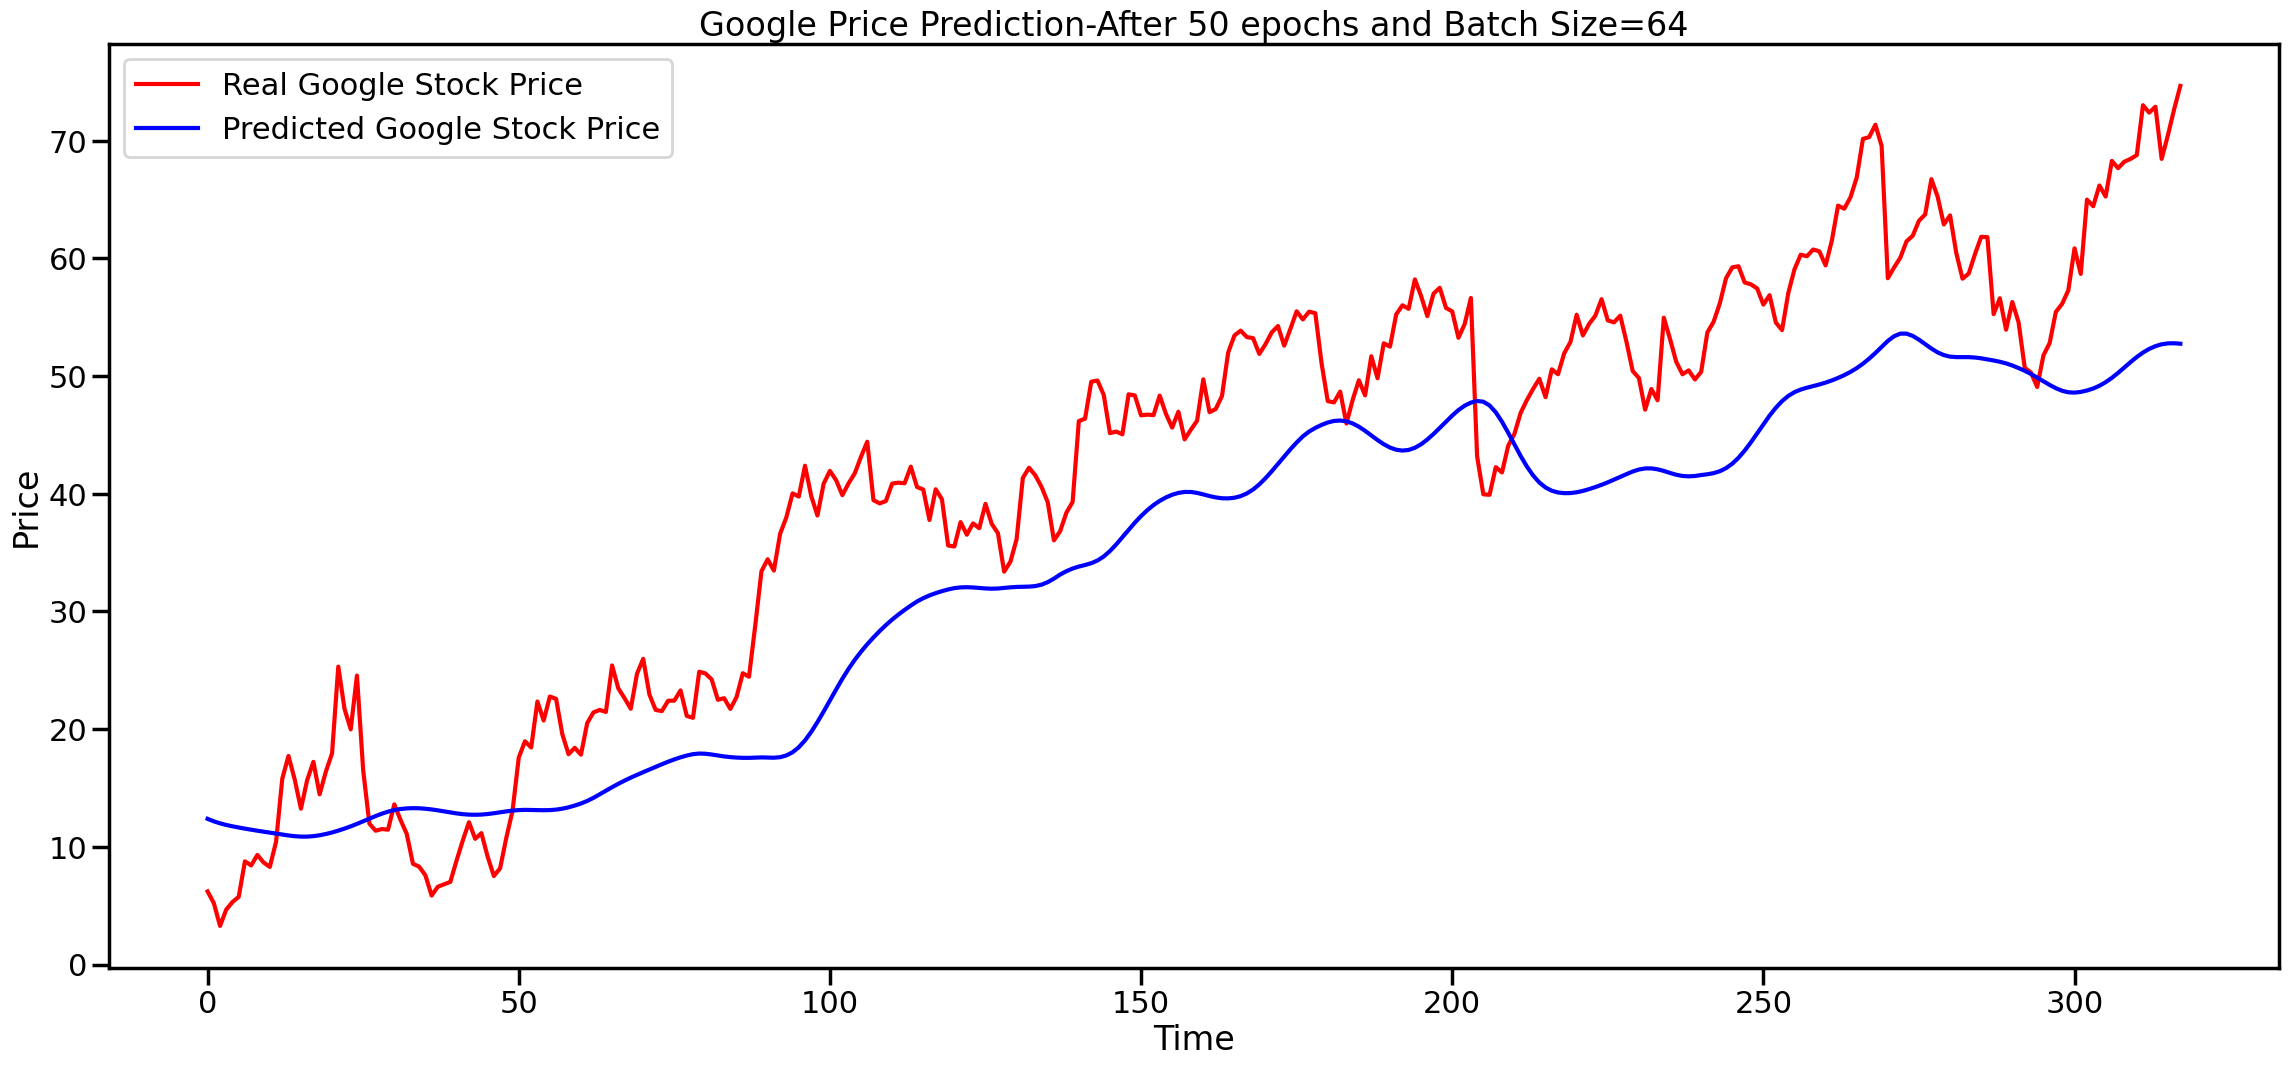

In [74]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(google_y_test, color = 'red', label = 'Real Google Stock Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Price Prediction-After 50 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()